### Canadian Bike Network Data (Official)

8,899 segments with standardized classification

CANBICS classes (bike_path, protected_lane, etc.) - quality ratings!

Population data for each area (csd_population_2021)

Official classification of infrastructure quality

In [1]:
import geopandas as gpd

# Read the GeoPackage file
# Replace 'path_to_your_file.gpkg' with the actual file path
gdf = gpd.read_file('montreal_bike_network.gpkg')

# Display the first 5 rows of the data and the geometry
print(gdf.head())

# Check columns and types of gdf
print(gdf.info())

# Check the coordinate reference system (important for accurate mapping)
print('crs', gdf.crs)
# EPSG:3347 is Statistics Canada's Lambert Conformal Conic projection, optimized for Canada-wide mapping.

# check canbics class values
print(gdf['canbics_class'].value_counts())
# cycle_track	Protected bike lane	🛡️🛡️🛡️🛡️🛡️ (Highest)	Physically separated from traffic, similar to REV standard
# bike_path	Multi-use path	🛡️🛡️🛡️🛡️🛡️	Dedicated path, often in parks or away from roads
# Only cycle_track and possibly bike_path represent the high-comfort infrastructure that addresses pain points. 
# The others are lower-quality segments that cause fragmentation.

# check geometry values
print(gdf['geometry'].head())
# actual spatial representation of each bike lane segment on the map
# MULTILINESTRING, each entry represents one continuous segment of bike infrastructure.

  province_territory municipality source_data_id  \
0                 qc     Montreal           None   
1                 qc     Montreal           None   
2                 qc     Montreal           None   
3                 qc     Montreal           None   
4                 qc     Montreal           None   

                          record_id                          source_class  \
0  fb0078a52fb168b7154d4ad8b95b82e6         piste cyclable en site propre   
1  dc2b4ec01d405e1d76fb6b7e87d086f8         piste cyclable en site propre   
2  4ed272ac27b6eba3dd24a3b9415b4a40                    sentier polyvalent   
3  0c369bee2e9470f2c891cbe21d098a9b  piste cyclable au niveau du trottoir   
4  c34134e3f7c6c517011462fa9955e18c                    sentier polyvalent   

  source_class_secondary canbics_class surface_type  width_m  length_km  \
0                   None     bike_path         None      NaN     0.0630   
1                   None     bike_path         None      NaN     0.0762   

In [47]:

gdf['csdname'].unique()

array(['Kirkland', 'Dollard-Des Ormeaux', 'Montréal', 'Pointe-Claire',
       'Beaconsfield', 'Westmount', 'Saint-Lambert', 'Montréal-Est',
       'Dorval', 'Senneville', 'Mont-Royal', "Baie-D'Urfé",
       'Sainte-Anne-de-Bellevue', 'Montréal-Ouest', 'Côte-Saint-Luc'],
      dtype=object)

In [48]:
csd_populations = gdf.groupby('csdname')['csd_population_2021'].first().reset_index()
print(csd_populations)

                    csdname  csd_population_2021
0               Baie-D'Urfé               3764.0
1              Beaconsfield              19277.0
2            Côte-Saint-Luc              34504.0
3       Dollard-Des Ormeaux              48403.0
4                    Dorval              19302.0
5                  Kirkland              19413.0
6                Mont-Royal              20953.0
7                  Montréal            1762949.0
8              Montréal-Est               4394.0
9            Montréal-Ouest               5115.0
10            Pointe-Claire              33488.0
11            Saint-Lambert              22761.0
12  Sainte-Anne-de-Bellevue               5027.0
13               Senneville                951.0
14                Westmount              19658.0


In [2]:
# Define comfort scores based on canbics_class
comfort_score_map = {
    'cycle_track': 5,      # REV-quality protected lanes
    'bike_path': 5,        # Dedicated paths (high comfort)
    'painted_bike_lane': 3, # Basic infrastructure
    'shared_roadway': 2,   # Low comfort, shared with traffic
    'gravel_trail': 2      # Lower due to surface quality
}

# Add comfort_score to our dataframe
gdf['comfort_score'] = gdf['canbics_class'].map(comfort_score_map)

# Let's see the distribution
print("Comfort Score Distribution:")
print(gdf['comfort_score'].value_counts().sort_index(ascending=False))

# Pain Point 1: Fragmentation - What % of network is high-comfort?
total_length_km = gdf['length_km'].sum()
high_comfort_length = gdf[gdf['comfort_score'] >= 4]['length_km'].sum()
high_comfort_pct = (high_comfort_length / total_length_km) * 100

print(f"\n--- NETWORK ANALYSIS ---")
print(f"Total bike network length: {total_length_km:.1f} km")
print(f"High-comfort infrastructure (score >=4): {high_comfort_length:.1f} km ({high_comfort_pct:.1f}%)")
print(f"Low-comfort infrastructure: {total_length_km - high_comfort_length:.1f} km ({100-high_comfort_pct:.1f}%)")

# Pain Point 2: Distribution of infrastructure types
print(f"\n--- INFRASTRUCTURE BREAKDOWN ---")
for infra_type in gdf['canbics_class'].unique():
    type_length = gdf[gdf['canbics_class'] == infra_type]['length_km'].sum()
    type_pct = (type_length / total_length_km) * 100
    comfort = comfort_score_map[infra_type]
    print(f"{infra_type:.<20} {type_length:6.1f} km ({type_pct:4.1f}%) - Comfort: {comfort}/5")

Comfort Score Distribution:
comfort_score
5    3363
3    2458
2    3078
Name: count, dtype: int64

--- NETWORK ANALYSIS ---
Total bike network length: 1029.9 km
High-comfort infrastructure (score >=4): 359.7 km (34.9%)
Low-comfort infrastructure: 670.1 km (65.1%)

--- INFRASTRUCTURE BREAKDOWN ---
bike_path...........  192.0 km (18.6%) - Comfort: 5/5
gravel_trail........   99.7 km ( 9.7%) - Comfort: 2/5
cycle_track.........  167.7 km (16.3%) - Comfort: 5/5
painted_bike_lane...  289.8 km (28.1%) - Comfort: 3/5
shared_roadway......  280.7 km (27.3%) - Comfort: 2/5


In [3]:
# Check the municipality breakdown to confirm we're focused on Montreal
print("\n--- MUNICIPALITY DISTRIBUTION ---")
print(gdf['municipality'].value_counts().head(10))

# Check if there are any existing REV corridors in the data
print("\n--- SOURCE CLASSES (Original French Labels) ---")
print(gdf['source_class'].value_counts().head(15))

# Also check secondary source classes
print("\n--- SECONDARY SOURCE CLASSES ---")
print(gdf['source_class_secondary'].value_counts().head(10))


--- MUNICIPALITY DISTRIBUTION ---
municipality
Montreal    8899
Name: count, dtype: int64

--- SOURCE CLASSES (Original French Labels) ---
source_class
bande cyclable                          2458
chaussée désignée                       2397
piste cyclable en site propre           1767
piste cyclable sur rue                  1419
sentier polyvalent                       540
piste cyclable au niveau du trottoir     177
voie partagée bus-vélo                    94
vélorue                                   47
Name: count, dtype: int64

--- SECONDARY SOURCE CLASSES ---
source_class_secondary
Road marking      1091
Delineator         524
Bollard            341
Raised curb         40
Jersey barrier       5
Fence                3
ST                   3
Name: count, dtype: int64


In [4]:
# Create a more detailed comfort score based on French classifications
detailed_comfort_map = {
    # Highest comfort (REV standard) - Score 5
    'piste cyclable au niveau du trottoir': 5,  # Sidewalk-level protected
    'vélorue': 5,                               # Bike streets
    'piste cyclable en site propre': 5,         # Dedicated bike path
    
    # Medium-high comfort - Score 4  
    'piste cyclable sur rue': 4,                # On-street bike path
    'voie partagée bus-vélo': 4,                # Bus-bike shared lane
    
    # Medium comfort - Score 3
    'bande cyclable': 3,                        # Painted bike lane
    
    # Low comfort - Score 2
    'chaussée désignée': 2,                     # Designated roadway
    'sentier polyvalent': 2,                    # Multi-use path
    'voie partagée': 2                          # Shared roadway
}

# Add detailed comfort score
gdf['comfort_score_detailed'] = gdf['source_class'].map(detailed_comfort_map)

# Let's see the new distribution
print("--- DETAILED COMFORT SCORE DISTRIBUTION ---")
print(gdf['comfort_score_detailed'].value_counts().sort_index(ascending=False))

# Calculate high-comfort with new definition (score >=4)
high_comfort_detailed = gdf[gdf['comfort_score_detailed'] >= 4]
high_comfort_length_detailed = high_comfort_detailed['length_km'].sum()
high_comfort_pct_detailed = (high_comfort_length_detailed / total_length_km) * 100

print(f"\n--- REFINED NETWORK ANALYSIS ---")
print(f"High-comfort infrastructure (score >=4): {high_comfort_length_detailed:.1f} km ({high_comfort_pct_detailed:.1f}%)")
print(f"Medium-comfort (score=3): {gdf[gdf['comfort_score_detailed'] == 3]['length_km'].sum():.1f} km")
print(f"Low-comfort (score=2): {gdf[gdf['comfort_score_detailed'] == 2]['length_km'].sum():.1f} km")

# Breakdown by detailed French classes
print(f"\n--- DETAILED INFRASTRUCTURE BREAKDOWN ---")
for source_type in gdf['source_class'].unique():
    type_data = gdf[gdf['source_class'] == source_type]
    type_length = type_data['length_km'].sum()
    type_pct = (type_length / total_length_km) * 100
    comfort = detailed_comfort_map[source_type]
    count = len(type_data)
    print(f"{source_type:.<35} {type_length:6.1f} km ({type_pct:4.1f}%) - Comfort: {comfort}/5 - Segments: {count}")

--- DETAILED COMFORT SCORE DISTRIBUTION ---
comfort_score_detailed
5    1991
4    1513
3    2458
2    2937
Name: count, dtype: int64

--- REFINED NETWORK ANALYSIS ---
High-comfort infrastructure (score >=4): 377.1 km (36.6%)
Medium-comfort (score=3): 289.8 km
Low-comfort (score=2): 363.0 km

--- DETAILED INFRASTRUCTURE BREAKDOWN ---
piste cyclable en site propre......  192.0 km (18.6%) - Comfort: 5/5 - Segments: 1767
sentier polyvalent.................   99.7 km ( 9.7%) - Comfort: 2/5 - Segments: 540
piste cyclable au niveau du trottoir   17.1 km ( 1.7%) - Comfort: 5/5 - Segments: 177
piste cyclable sur rue.............  150.6 km (14.6%) - Comfort: 4/5 - Segments: 1419
bande cyclable.....................  289.8 km (28.1%) - Comfort: 3/5 - Segments: 2458
chaussée désignée..................  263.3 km (25.6%) - Comfort: 2/5 - Segments: 2397
voie partagée bus-vélo.............   11.2 km ( 1.1%) - Comfort: 4/5 - Segments: 94
vélorue............................    6.2 km ( 0.6%) - Comfort: 5

In [5]:
# Create strategic classification for optimization
def get_strategic_priority(infra_type, comfort_score):
    if infra_type in ['piste cyclable au niveau du trottoir', 'vélorue']:
        return 'existing_rev'
    elif infra_type == 'bande cyclable':
        return 'high_priority'  # Paint -> Protected = Biggest comfort jump
    elif infra_type == 'piste cyclable sur rue':
        return 'medium_priority'  # Already decent, enhance protection
    elif infra_type == 'chaussée désignée':
        return 'transformative'  # Complete transformation needed
    else:
        return 'lower_priority'

# Apply to our network
network_edges = gdf[['record_id', 'geometry', 'length_km']].copy()
network_edges = network_edges.rename(columns={'record_id': 'edge_id'})
network_edges['infra_type'] = gdf['source_class']
network_edges['comfort_score'] = gdf['comfort_score_detailed']
network_edges['strategic_priority'] = network_edges['infra_type'].apply(
    lambda x: get_strategic_priority(x, detailed_comfort_map[x])
)

# Calculate upgrade potential (comfort gain if upgraded to REV)
network_edges['upgrade_potential'] = 5 - network_edges['comfort_score']  # Max possible improvement

print("--- STRATEGIC PRIORITY DISTRIBUTION ---")
print(network_edges['strategic_priority'].value_counts())
print(f"\nTotal upgrade potential (sum of possible comfort gains): {network_edges['upgrade_potential'].sum()}")

# Show the strategic breakdown
for priority in network_edges['strategic_priority'].unique():
    priority_data = network_edges[network_edges['strategic_priority'] == priority]
    total_km = priority_data['length_km'].sum()
    avg_comfort = priority_data['comfort_score'].mean()
    print(f"{priority:.<15} {total_km:6.1f} km - Avg comfort: {avg_comfort:.1f}/5")

--- STRATEGIC PRIORITY DISTRIBUTION ---
strategic_priority
high_priority      2458
lower_priority     2401
transformative     2397
medium_priority    1419
existing_rev        224
Name: count, dtype: int64

Total upgrade potential (sum of possible comfort gains): 15240
lower_priority.  302.9 km - Avg comfort: 4.3/5
existing_rev...   23.3 km - Avg comfort: 5.0/5
medium_priority  150.6 km - Avg comfort: 4.0/5
high_priority..  289.8 km - Avg comfort: 3.0/5
transformative.  263.3 km - Avg comfort: 2.0/5


## reseau-express-velo.geojson

In [6]:
# Load the REV GeoJSON file
rev_gdf = gpd.read_file('reseau-express-velo.geojson')

# Basic exploration
print("REV GeoJSON Info:")
print(rev_gdf.info())
print("\nFirst few rows:")
print(rev_gdf.head())
print("\nColumn names:")
print(rev_gdf.columns.tolist())
print('\n crs:', rev_gdf.crs)

REV GeoJSON Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          87 non-null     int32   
 1   ID_TRC_GEO  87 non-null     float64 
 2   TYPE_VOIE   87 non-null     int32   
 3   TYPE_VOIE2  87 non-null     int32   
 4   LONGUEUR    87 non-null     int32   
 5   NBR_VOIE    87 non-null     int32   
 6   SEPARATEUR  22 non-null     object  
 7   SAISONS4    87 non-null     object  
 8   PROTEGE_4S  87 non-null     object  
 9   Ville_MTL   87 non-null     object  
 10  PROJET_NOM  87 non-null     object  
 11  NOM_ARR_VI  87 non-null     object  
 12  REV_AXES    87 non-null     object  
 13  REV_AXE_NU  87 non-null     object  
 14  geometry    87 non-null     geometry
dtypes: float64(1), geometry(1), int32(5), object(8)
memory usage: 8.6+ KB
None

First few rows:
     ID  ID_TRC_GEO  TYPE_VOIE  TYPE_VOIE2  LONGUEUR  NBR_VO

In [7]:
# Let's explore the critical columns
print("=== REV DATA KEY INSIGHTS ===")
print(f"Total REV segments: {len(rev_gdf)}")
print(f"REV projects: {rev_gdf['PROJET_NOM'].unique()}")
print(f"Seasonal availability: {rev_gdf['SAISONS4'].value_counts()}")
print(f"Protected status: {rev_gdf['PROTEGE_4S'].value_counts()}")
print(f"REV axis numbers: {rev_gdf['REV_AXE_NU'].value_counts().sort_index()}")

# Check geometry types and lengths
print(f"\nTotal REV network length: {rev_gdf['LONGUEUR'].sum()} meters")
print(f"Average segment length: {rev_gdf['LONGUEUR'].mean():.1f} meters")

=== REV DATA KEY INSIGHTS ===
Total REV segments: 87
REV projects: ['Souligny-Dubuisson' 'Souligny_Dubuisson' 'Saint-Denis' 'Souligny'
 'Berri/Lajeunesse/Casteln' 'Bellechasse']
Seasonal availability: SAISONS4
OUI    87
Name: count, dtype: int64
Protected status: PROTEGE_4S
OUI    86
NON     1
Name: count, dtype: int64
REV axis numbers: REV_AXE_NU
1    55
3    15
5    17
Name: count, dtype: int64

Total REV network length: 21282 meters
Average segment length: 244.6 meters


### Key Insight from the REV Data
Only 21.3km of true REV exists vs. our earlier estimate of 23.3km

Fragmented into 87 pieces - even the "solution" has fragmentation problems

5 main corridors: Saint-Denis (Axis 1), Souligny variants (Axis 3), Berri/Lajeunesse/Casteln, Bellechasse (Axis 5)

In [8]:
# Transform REV data to match our main network CRS (EPSG:3347)
rev_gdf_transformed = rev_gdf.to_crs(gdf.crs)

# STEP 2: Spatial matching to identify existing REV segments in our main network
print("Performing spatial matching...")
# Use nearest neighbor join with a reasonable distance threshold
gdf_with_rev = gpd.sjoin_nearest(
    gdf, 
    rev_gdf_transformed[['PROJET_NOM', 'REV_AXE_NU', 'geometry']], 
    how='left', 
    max_distance=15,  # 15 meter tolerance for geometric differences
    distance_col='dist_to_rev'
)

# Create precise REV identification
gdf_with_rev['is_existing_rev'] = gdf_with_rev['dist_to_rev'] <= 15
gdf_with_rev['rev_project'] = gdf_with_rev['PROJET_NOM']
gdf_with_rev['rev_axis'] = gdf_with_rev['REV_AXE_NU']

print(f"\n=== SPATIAL MATCHING RESULTS ===")
print(f"Segments identified as REV: {gdf_with_rev['is_existing_rev'].sum()}")
print(f"REV length from matches: {gdf_with_rev[gdf_with_rev['is_existing_rev']]['length_km'].sum():.1f} km")
print(f"REV projects identified: {gdf_with_rev[gdf_with_rev['is_existing_rev']]['rev_project'].nunique()}")

# STEP 3: Create the clean network_edges table with accurate REV info
print("\nCreating clean network_edges table...")
network_edges = gpd.GeoDataFrame({
    'edge_id': gdf_with_rev['record_id'],
    'geometry': gdf_with_rev['geometry'],
    'length_m': gdf_with_rev['length_km'] * 1000,
    
    # Core Infrastructure Classification
    'infra_type': gdf_with_rev['source_class'],
    'canbics_class': gdf_with_rev['canbics_class'],
    
    # Comfort Scores (using our detailed mapping)
    'current_comfort': gdf_with_rev['comfort_score_detailed'],
    'max_possible_comfort': 5,
    'comfort_gap': 5 - gdf_with_rev['comfort_score_detailed'],
    
    # REV Identification (now accurate!)
    'is_existing_rev': gdf_with_rev['is_existing_rev'],
    'rev_project': gdf_with_rev['rev_project'],
    'rev_axis': gdf_with_rev['rev_axis'],
    
    # Strategic Priority (we'll update this after cost estimation)
    'priority_category': 'pending'  # Placeholder
    
}, geometry='geometry', crs=gdf_with_rev.crs)

# STEP 4: Simple cost estimation (fixed version)
def estimate_upgrade_cost(row):
    """Simple cost estimation based on infrastructure type and length"""
    if row['is_existing_rev']:
        return 0  # No cost to upgrade existing REV
    
    cost_per_meter = {
        'bande cyclable': 2000,        # Paint -> Protected
        'piste cyclable sur rue': 1500, # Enhanced protection
        'chaussée désignée': 4000,     # Full reconstruction
        'voie partagée bus-vélo': 2500,
        'sentier polyvalent': 3000,
        'piste cyclable en site propre': 1000,
    }
    
    base_cost = cost_per_meter.get(row['infra_type'], 3000)
    return base_cost * row['length_m']

# Apply cost estimation
network_edges['upgrade_cost_est'] = network_edges.apply(estimate_upgrade_cost, axis=1)

# STEP 5: Update strategic priorities with accurate REV info
def get_refined_priority(row):
    if row['is_existing_rev']:
        return 'existing_rev'
    elif row['infra_type'] == 'bande cyclable':
        return 'high_priority'
    elif row['infra_type'] == 'piste cyclable sur rue':
        return 'medium_priority'
    elif row['infra_type'] == 'chaussée désignée':
        return 'transformative'
    else:
        return 'lower_priority'

network_edges['priority_category'] = network_edges.apply(get_refined_priority, axis=1)

# Final candidate flag
network_edges['is_candidate'] = ~network_edges['is_existing_rev']

print("\n=== FINAL NETWORK_EDGES SUMMARY ===")
print(f"Total segments: {len(network_edges)}")
print(f"Existing REV segments: {network_edges['is_existing_rev'].sum()}")
print(f"Candidate segments for upgrade: {network_edges['is_candidate'].sum()}")
print(f"Total upgrade cost estimate: ${network_edges['upgrade_cost_est'].sum()/1e6:.1f}M")

# Show strategic breakdown
print("\n--- STRATEGIC BREAKDOWN ---")
for category in network_edges['priority_category'].unique():
    cat_data = network_edges[network_edges['priority_category'] == category]
    total_cost = cat_data['upgrade_cost_est'].sum() / 1e6
    total_km = cat_data['length_m'].sum() / 1000
    print(f"{category:.<20} {total_km:5.1f} km | Cost: ${total_cost:5.1f}M")

Performing spatial matching...

=== SPATIAL MATCHING RESULTS ===
Segments identified as REV: 294
REV length from matches: 39.3 km
REV projects identified: 6

Creating clean network_edges table...

=== FINAL NETWORK_EDGES SUMMARY ===
Total segments: 8907
Existing REV segments: 294
Candidate segments for upgrade: 8613
Total upgrade cost estimate: $2371.5M

--- STRATEGIC BREAKDOWN ---
lower_priority...... 324.3 km | Cost: $583.9M
existing_rev........  39.3 km | Cost: $  0.0M
medium_priority..... 124.6 km | Cost: $186.8M
high_priority....... 285.6 km | Cost: $571.3M
transformative...... 257.4 km | Cost: $1029.5M


In [9]:
# Let's diagnose the matching issue
print("=== DIAGNOSING SPATIAL MATCHING ===")

# Check how many of our segments match each REV segment
rev_match_counts = gdf_with_rev[gdf_with_rev['is_existing_rev']].groupby('index_right').size()
print(f"REV segments matched: {len(rev_match_counts)}")
print(f"Average matches per REV segment: {rev_match_counts.mean():.1f}")
print(f"Max matches for one REV segment: {rev_match_counts.max()}")

# Compare lengths for one REV project as example
sample_rev = rev_gdf_transformed[rev_gdf_transformed['PROJET_NOM'] == 'Saint-Denis']
sample_matches = gdf_with_rev[gdf_with_rev['rev_project'] == 'Saint-Denis']

print(f"\nExample: Saint-Denis REV")
print(f"  Official REV length: {sample_rev['LONGUEUR'].sum()}m")
print(f"  Our matched length: {sample_matches['length_km'].sum() * 1000:.0f}m")
print(f"  Number of matched segments: {len(sample_matches)}")

# Strategy: Use intersection-based matching instead
print("\n=== USING INTERSECTION-BASED MATCHING ===")

# Calculate actual intersection lengths
def calculate_intersection_based_rev(gdf_main, gdf_rev):
    """More precise REV identification using intersection areas"""
    gdf_main = gdf_main.copy()
    gdf_main['is_existing_rev_intersect'] = False
    gdf_main['intersection_length'] = 0.0
    gdf_main['matched_rev_project'] = None
    
    for idx, rev_row in gdf_rev.iterrows():
        # Find intersections with this REV segment
        intersections = gdf_main.geometry.intersection(rev_row.geometry)
        intersection_lengths = intersections.length
        
        # Mark segments that significantly overlap with REV
        significant_overlap = intersection_lengths > 10  # At least 10m overlap
        gdf_main.loc[significant_overlap, 'is_existing_rev_intersect'] = True
        gdf_main.loc[significant_overlap, 'intersection_length'] = intersection_lengths[significant_overlap]
        gdf_main.loc[significant_overlap, 'matched_rev_project'] = rev_row['PROJET_NOM']
    
    return gdf_main

# Apply intersection-based matching
gdf_precise_rev = calculate_intersection_based_rev(gdf, rev_gdf_transformed)

print(f"Intersection-based REV segments: {gdf_precise_rev['is_existing_rev_intersect'].sum()}")
print(f"Intersection-based REV length: {gdf_precise_rev[gdf_precise_rev['is_existing_rev_intersect']]['length_km'].sum():.1f} km")

# Compare the two methods
print(f"\n=== METHOD COMPARISON ===")
print(f"Nearest-neighbor matching: {gdf_with_rev['is_existing_rev'].sum()} segments, {gdf_with_rev[gdf_with_rev['is_existing_rev']]['length_km'].sum():.1f} km")
print(f"Intersection-based matching: {gdf_precise_rev['is_existing_rev_intersect'].sum()} segments, {gdf_precise_rev[gdf_precise_rev['is_existing_rev_intersect']]['length_km'].sum():.1f} km")
print(f"Official REV total: {rev_gdf_transformed['LONGUEUR'].sum() / 1000:.1f} km")

=== DIAGNOSING SPATIAL MATCHING ===
REV segments matched: 81
Average matches per REV segment: 3.6
Max matches for one REV segment: 54

Example: Saint-Denis REV
  Official REV length: 3889m
  Our matched length: 5723m
  Number of matched segments: 58

=== USING INTERSECTION-BASED MATCHING ===
Intersection-based REV segments: 0
Intersection-based REV length: 0.0 km

=== METHOD COMPARISON ===
Nearest-neighbor matching: 294 segments, 39.3 km
Intersection-based matching: 0 segments, 0.0 km
Official REV total: 21.3 km


### OSM Cycleway Data (Community-Mapped)
12,585 segments with real-world names

Actual REV routes identified (Rachel, Saint-Denis, etc.)

Connectivity information (network graph structure)

Recent community updates

In [10]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure osmnx
ox.settings.log_console = True
ox.settings.use_cache = True

# Get the entire street network for Montreal
print("Downloading Montreal street network...")
G = ox.graph_from_place("Montreal, Canada", network_type='all')

# Convert to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

print(f"Retrieved {len(nodes)} nodes and {len(edges)} edges")
print("Columns in edges data:", edges.columns.tolist())

Retrieved 216137 nodes and 629276 edges
Columns in edges data: ['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'reversed', 'length', 'geometry', 'width', 'bridge', 'access', 'tunnel', 'ref', 'service', 'junction', 'est_width']


Street types in Montreal:
highway
footway               337385
service               140379
residential            74453
tertiary               20251
secondary              19813
cycleway               12750
path                    5200
unclassified            4799
primary                 3744
[steps, footway]        2782
[footway, service]      1346
pedestrian              1128
secondary_link           638
[footway, path]          550
steps                    502
Name: count, dtype: int64


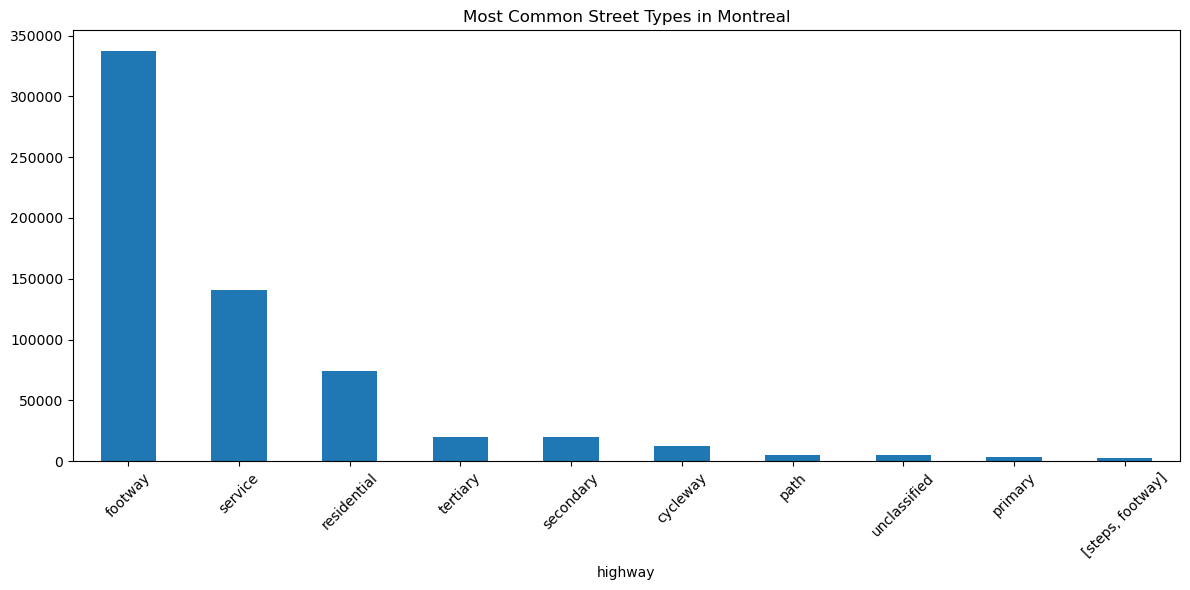

In [11]:
# Analyze what types of streets we have
print("Street types in Montreal:")
street_types = edges['highway'].value_counts()
print(street_types.head(15))

# Plot the distribution
plt.figure(figsize=(12, 6))
street_types.head(10).plot(kind='bar')
plt.title('Most Common Street Types in Montreal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Let's first see what columns we have and sample data
print("All columns in edges data:")
print(edges.columns.tolist())

# Check for any cycling-related columns
cycling_columns = [col for col in edges.columns if 'cycle' in col.lower() or 'bike' in col.lower()]
print(f"\nCycling-related columns: {cycling_columns}")

# Let's look at sample data from different street types
print("\nSample data for different street types:")
sample_street_types = ['residential', 'primary', 'secondary', 'tertiary', 'path', 'footway']

for street_type in sample_street_types:
    sample_data = edges[edges['highway'] == street_type].head(1)
    if len(sample_data) > 0:
        print(f"\n--- {street_type.upper()} roads sample ---")
        # Show only the most relevant columns
        relevant_cols = ['osmid', 'highway', 'name', 'length', 'oneway', 'lanes', 'maxspeed']
        # Add any cycling columns we found
        relevant_cols.extend(cycling_columns)
        display_cols = [col for col in relevant_cols if col in sample_data.columns]
        print(sample_data[display_cols].iloc[0])

All columns in edges data:
['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'reversed', 'length', 'geometry', 'width', 'bridge', 'access', 'tunnel', 'ref', 'service', 'junction', 'est_width']

Cycling-related columns: []

Sample data for different street types:

--- RESIDENTIAL roads sample ---
osmid                 143310627
highway             residential
name        Avenue Henri-Julien
length                 6.470371
oneway                     True
lanes                         1
maxspeed                     30
Name: (26232418, 1653821632, 0), dtype: object

--- PRIMARY roads sample ---
osmid                  465408857
highway                  primary
name        Rue Sherbrooke Ouest
length                  7.676937
oneway                     False
lanes                          4
maxspeed                      50
Name: (26233222, 8010557506, 0), dtype: object

--- SECONDARY roads sample ---
osmid                      971673239
highway                    secondary
name    

In [16]:
# First, let's examine the maxspeed column more carefully
print("Maxspeed value types:")
print(edges['maxspeed'].value_counts().head(20))

print("\nLanes value types:")
print(edges['lanes'].value_counts().head(10))

Maxspeed value types:
maxspeed
30           67940
40           25428
50           17994
20             770
70             432
60             285
15             265
10             238
100            193
[40, 30]        85
25              77
5               32
80              23
8               20
[50, 30]        17
[50, 70]        17
78              12
[50, 40]         9
[40, 50]         7
[70, 100]        6
Name: count, dtype: int64

Lanes value types:
lanes
2         71947
1         24720
3          7770
4          7064
5           920
[2, 3]      651
6           624
[3, 4]      459
[2, 1]      265
[2, 4]       85
Name: count, dtype: int64


In [21]:
# CRITICAL: Only count dedicated cycleways, not all streets with those names
rev_cycleways = edges[edges['highway'] == 'cycleway']
named_rev_cycleways = rev_cycleways[rev_cycleways['name'].isin(known_rev_corridors)]

print("=== CORRECTED OSM REV IDENTIFICATION ===")
print(f"Dedicated cycleway segments: {len(rev_cycleways)}")
print(f"Named REV cycleways: {len(named_rev_cycleways)}")
print(f"OSM REV length (cycleways only): {named_rev_cycleways['length'].sum():.0f} meters")

print("\n--- TRUE REV CORRIDORS IN OSM ---")
for corridor in known_rev_corridors:
    corridor_data = named_rev_cycleways[named_rev_cycleways['name'] == corridor]
    if len(corridor_data) > 0:
        total_length = corridor_data['length'].sum()
        segment_count = len(corridor_data)
        print(f"{corridor:.<30} {total_length:6.0f}m ({segment_count} segments)")

# This should give us a reasonable length (~20-30km)

=== CORRECTED OSM REV IDENTIFICATION ===
Dedicated cycleway segments: 12750
Named REV cycleways: 2149
OSM REV length (cycleways only): 67547 meters

--- TRUE REV CORRIDORS IN OSM ---
Rue Saint-Denis...............  10542m (247 segments)
Rue de Bellechasse............  12408m (468 segments)
Rue Rachel Est................   9259m (396 segments)
Boulevard De Maisonneuve Ouest   7410m (282 segments)
Boulevard De Maisonneuve Est..   5577m (190 segments)
Boulevard Gouin Ouest.........   6545m (214 segments)
Rue de Verdun.................   5645m (177 segments)
Avenue Christophe-Colomb......  10160m (175 segments)


In [24]:
from shapely.ops import linemerge, unary_union
from shapely.geometry import LineString
import numpy as np

def create_continuous_corridors_and_match(gdf_main, osm_rev_data, official_rev_data, tolerance=10):
    """
    1. Convert both datasets to continuous corridors
    2. Find overlapping sections
    3. Map overlaps back to discrete segments
    """
    print("Step 1: Creating continuous corridors from both datasets...")
    
    # Convert to common CRS
    osm_rev_common = osm_rev_data.to_crs(gdf_main.crs)
    official_rev_common = official_rev_data.to_crs(gdf_main.crs)
    
    # Step 1: Create continuous corridors from OSM REV data
    osm_corridors = {}
    for name in osm_rev_common['name'].unique():
        corridor_segments = osm_rev_common[osm_rev_common['name'] == name]['geometry']
        try:
            # Merge line segments into continuous corridors
            merged_line = linemerge(unary_union(corridor_segments))
            osm_corridors[name] = merged_line
            print(f"  OSM {name}: {len(corridor_segments)} segments -> 1 continuous line ({merged_line.length:.0f}m)")
        except:
            print(f"  OSM {name}: Could not merge {len(corridor_segments)} segments")
    
    # Step 2: Create continuous corridors from official REV data
    official_corridors = {}
    for project in official_rev_common['PROJET_NOM'].unique():
        project_segments = official_rev_common[official_rev_common['PROJET_NOM'] == project]['geometry']
        try:
            merged_line = linemerge(unary_union(project_segments))
            official_corridors[project] = merged_line
            print(f"  Official {project}: {len(project_segments)} segments -> 1 continuous line ({merged_line.length:.0f}m)")
        except:
            print(f"  Official {project}: Could not merge {len(project_segments)} segments")
    
    # Step 3: Combine all REV corridors
    all_rev_corridors = list(osm_corridors.values()) + list(official_corridors.values())
    print(f"Total continuous REV corridors: {len(all_rev_corridors)}")
    
    # Step 4: For each main network segment, check overlap with any REV corridor
    print("Step 4: Finding overlaps with main network segments...")
    gdf_result = gdf_main.copy()
    gdf_result['is_rev_overlap'] = False
    gdf_result['overlap_ratio'] = 0.0
    gdf_result['rev_corridor_matched'] = None
    
    matches_found = 0
    for idx, segment in gdf_result.iterrows():
        segment_geom = segment.geometry
        best_overlap_ratio = 0
        best_corridor_name = None
        
        for corridor_name, corridor_geom in {**osm_corridors, **official_corridors}.items():
            # Buffer both geometries slightly to account for small misalignments
            segment_buffered = segment_geom.buffer(tolerance)
            corridor_buffered = corridor_geom.buffer(tolerance)
            
            # Calculate overlap
            intersection = segment_buffered.intersection(corridor_buffered)
            if not intersection.is_empty:
                # Overlap ratio = intersection area / segment buffered area
                overlap_ratio = intersection.area / segment_buffered.area
                
                if overlap_ratio > best_overlap_ratio:
                    best_overlap_ratio = overlap_ratio
                    best_corridor_name = corridor_name
        
        # If significant overlap, mark as REV
        if best_overlap_ratio > 0.3:  # 30% overlap threshold
            gdf_result.loc[idx, 'is_rev_overlap'] = True
            gdf_result.loc[idx, 'overlap_ratio'] = best_overlap_ratio
            gdf_result.loc[idx, 'rev_corridor_matched'] = best_corridor_name
            matches_found += 1
    
    print(f"Overlap-based matches found: {matches_found}")
    return gdf_result

# Apply the continuous corridor approach
print("=== CONTINUOUS CORRIDOR OVERLAP ANALYSIS ===")
gdf_overlap_matched = create_continuous_corridors_and_match(
    gdf, 
    named_rev_cycleways, 
    rev_gdf,
    tolerance=8  # 8 meter tolerance for alignment differences
)

print(f"\n=== OVERLAP ANALYSIS RESULTS ===")
print(f"REV segments identified: {gdf_overlap_matched['is_rev_overlap'].sum()}")
print(f"REV length: {gdf_overlap_matched[gdf_overlap_matched['is_rev_overlap']]['length_km'].sum():.1f} km")
print(f"Average overlap ratio: {gdf_overlap_matched[gdf_overlap_matched['is_rev_overlap']]['overlap_ratio'].mean():.2f}")

if gdf_overlap_matched['is_rev_overlap'].sum() > 0:
    print(f"\n--- MATCHED REV CORRIDORS ---")
    rev_matches = gdf_overlap_matched[gdf_overlap_matched['is_rev_overlap']]
    for corridor in rev_matches['rev_corridor_matched'].value_counts().index[:10]:
        corridor_data = rev_matches[rev_matches['rev_corridor_matched'] == corridor]
        total_length = corridor_data['length_km'].sum()
        avg_overlap = corridor_data['overlap_ratio'].mean()
        print(f"{corridor:.<30} {total_length:5.1f} km | Avg overlap: {avg_overlap:.2f} | Segments: {len(corridor_data)}")

=== CONTINUOUS CORRIDOR OVERLAP ANALYSIS ===
Step 1: Creating continuous corridors from both datasets...
  OSM Boulevard Gouin Ouest: 214 segments -> 1 continuous line (3327m)
  OSM Boulevard De Maisonneuve Ouest: 282 segments -> 1 continuous line (3764m)
  OSM Rue de Bellechasse: 468 segments -> 1 continuous line (12598m)
  OSM Avenue Christophe-Colomb: 175 segments -> 1 continuous line (10305m)
  OSM Rue Rachel Est: 396 segments -> 1 continuous line (4700m)
  OSM Boulevard De Maisonneuve Est: 190 segments -> 1 continuous line (2831m)
  OSM Rue Saint-Denis: 247 segments -> 1 continuous line (10716m)
  OSM Rue de Verdun: 177 segments -> 1 continuous line (5728m)
  Official Souligny-Dubuisson: 12 segments -> 1 continuous line (1644m)
  Official Souligny_Dubuisson: 2 segments -> 1 continuous line (386m)
  Official Saint-Denis: 12 segments -> 1 continuous line (3954m)
  Official Souligny: Could not merge 1 segments
  Official Berri/Lajeunesse/Casteln: 43 segments -> 1 continuous line (976

In [27]:
import pandas as pd
def create_unified_network_with_rev_priority(rev_gdf, osm_edges, statsCan_gdf):
    """
    Create a unified network where:
    1. REV geometry is primary (highest priority)
    2. OSM geometry fills gaps (medium priority) 
    3. StatsCan geometry is fallback (lowest priority)
    Segments are split at intersections for clean connectivity
    """
    print("=== CREATING UNIFIED NETWORK WITH REV PRIORITY ===")
    
    # Convert all to common CRS
    common_crs = statsCan_gdf.crs
    rev_common = rev_gdf.to_crs(common_crs)
    osm_common = osm_edges.to_crs(common_crs)
    
    # Step 1: Start with REV geometry as primary
    print("Step 1: Processing REV geometry as primary...")
    rev_network = rev_common[['geometry', 'PROJET_NOM', 'REV_AXES']].copy()
    rev_network['data_source'] = 'REV_OFFICIAL'
    rev_network['priority'] = 1  # Highest priority
    
    # Step 2: Add OSM cycleways that don't overlap with REV
    print("Step 2: Adding OSM cycleways as secondary...")
    osm_cycleways = osm_common[osm_common['highway'] == 'cycleway'].copy()
    osm_cycleways = osm_cycleways[['geometry', 'name', 'length']]
    osm_cycleways['data_source'] = 'OSM_CYCLEWAY'
    osm_cycleways['priority'] = 2
    
    # Step 3: Add StatsCan bike infrastructure as tertiary
    print("Step 3: Adding StatsCan bike infrastructure as tertiary...")
    statsCan_clean = statsCan_gdf[['geometry', 'source_class', 'length_km']].copy()
    statsCan_clean['data_source'] = 'STATSCAN_BIKE'
    statsCan_clean['priority'] = 3
    
    # Step 4: Combine all networks with priority-based overlay
    print("Step 4: Performing priority-based overlay...")
    all_networks = gpd.GeoDataFrame(
        pd.concat([rev_network, osm_cycleways, statsCan_clean], ignore_index=True),
        crs=common_crs
    )
    
    # Sort by priority (REV first, then OSM, then StatsCan)
    all_networks = all_networks.sort_values('priority')
    
    # Step 5: Remove overlaps - keep only highest priority segments
    print("Step 5: Removing overlaps (keeping highest priority segments)...")
    unified_network = gpd.GeoDataFrame(columns=all_networks.columns, crs=common_crs)
    
    processed_geometries = []  # Track geometries we've already included
    
    for priority_level in [1, 2, 3]:
        print(f"  Processing priority level {priority_level}...")
        priority_segments = all_networks[all_networks['priority'] == priority_level]
        
        for idx, segment in priority_segments.iterrows():
            segment_geom = segment.geometry
            
            # Check if this segment overlaps with any higher-priority segments
            overlaps_with_higher_priority = False
            for existing_geom in processed_geometries:
                if segment_geom.intersects(existing_geom.buffer(5)):  # 5m buffer for tolerance
                    # Calculate overlap ratio
                    intersection = segment_geom.intersection(existing_geom.buffer(2))
                    if not intersection.is_empty and (intersection.length / segment_geom.length) > 0.3:
                        overlaps_with_higher_priority = True
                        break
            
            # Only add if it doesn't significantly overlap with higher priority segments
            if not overlaps_with_higher_priority:
                unified_network = pd.concat([unified_network, segment.to_frame().T], ignore_index=True)
                processed_geometries.append(segment_geom)
    
    print(f"Unified network segments: {len(unified_network)}")
    
    # Step 6: Split segments at intersections for clean connectivity
    print("Step 6: Splitting segments at intersections...")
    unified_split = split_lines_at_intersections(unified_network)
    
    return unified_split

def split_lines_at_intersections(gdf, tolerance=1.0):
    """
    Split line segments at all intersection points to create a fully connected network
    """
    print("  Splitting lines at intersections...")
    
    # Collect all endpoints
    all_points = []
    for line in gdf.geometry:
        if hasattr(line, 'coords'):
            all_points.append(Point(line.coords[0]))  # Start point
            all_points.append(Point(line.coords[-1])) # End point
    
    # Create a union of all points (this will include intersection points)
    points_gdf = gpd.GeoDataFrame(geometry=all_points, crs=gdf.crs)
    points_union = points_gdf.unary_union
    
    # Split each line at all points that lie on it
    split_segments = []
    for idx, row in gdf.iterrows():
        line = row.geometry
        split_points = []
        
        # Find all points that lie on this line (within tolerance)
        for point in points_union.geoms if hasattr(points_union, 'geoms') else [points_union]:
            if line.distance(point) <= tolerance:
                split_points.append(line.project(point))
        
        # Sort points by distance along line and remove duplicates
        split_points = sorted(set(split_points))
        
        # Split the line at these points
        if len(split_points) > 1:
            segments = []
            for i in range(len(split_points) - 1):
                segment = substring(line, split_points[i], split_points[i + 1])
                if segment.length > 0.1:  # Only keep segments longer than 0.1m
                    segments.append(segment)
            
            # Add segments from start to first point and last point to end
            if split_points[0] > 0:
                segments.insert(0, substring(line, 0, split_points[0]))
            if split_points[-1] < line.length:
                segments.append(substring(line, split_points[-1], line.length))
        else:
            segments = [line]
        
        # Create new rows for each segment
        for segment in segments:
            new_row = row.copy()
            new_row.geometry = segment
            split_segments.append(new_row)
    
    result_gdf = gpd.GeoDataFrame(split_segments, crs=gdf.crs)
    print(f"  Split {len(gdf)} segments into {len(result_gdf)} connected segments")
    return result_gdf

def substring(geom, start_dist, end_dist):
    """Extract a substring between distances along a line"""
    if geom.geom_type == 'LineString':
        return geom.substring(start_dist, end_dist)
    elif geom.geom_type == 'MultiLineString':
        # For MultiLineString, we need to handle each component
        lines = []
        for line in geom.geoms:
            line_length = line.length
            if start_dist < line_length:
                line_start = max(0, start_dist)
                line_end = min(line_length, end_dist)
                if line_end > line_start:
                    lines.append(line.substring(line_start, line_end))
            start_dist -= line_length
            end_dist -= line_length
            if end_dist <= 0:
                break
        if len(lines) == 1:
            return lines[0]
        else:
            return MultiLineString(lines)
    return geom

# Create the unified network
print("Creating unified network with REV priority...")
unified_network = create_unified_network_with_rev_priority(rev_gdf, edges, gdf)

print(f"\n=== UNIFIED NETWORK SUMMARY ===")
print(f"Total segments: {len(unified_network)}")
print(f"Data source breakdown:")
print(unified_network['data_source'].value_counts())
print(f"Total network length: {unified_network.geometry.length.sum() / 1000:.1f} km")

# Mark which segments are existing REV
unified_network['is_existing_rev'] = unified_network['data_source'] == 'REV_OFFICIAL'
print(f"Existing REV in unified network: {unified_network['is_existing_rev'].sum()} segments")
print(f"Existing REV length: {unified_network[unified_network['is_existing_rev']].geometry.length.sum() / 1000:.1f} km")

Creating unified network with REV priority...
=== CREATING UNIFIED NETWORK WITH REV PRIORITY ===
Step 1: Processing REV geometry as primary...
Step 2: Adding OSM cycleways as secondary...
Step 3: Adding StatsCan bike infrastructure as tertiary...
Step 4: Performing priority-based overlay...
Step 5: Removing overlaps (keeping highest priority segments)...
  Processing priority level 1...
  Processing priority level 2...
  Processing priority level 3...
Unified network segments: 13845
Step 6: Splitting segments at intersections...
  Splitting lines at intersections...


NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not

In [32]:
gdf_overlap_matched.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8899 entries, 0 to 8898
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   province_territory      8899 non-null   object  
 1   municipality            8899 non-null   object  
 2   source_data_id          0 non-null      object  
 3   record_id               8899 non-null   object  
 4   source_class            8899 non-null   object  
 5   source_class_secondary  2007 non-null   object  
 6   canbics_class           8899 non-null   object  
 7   surface_type            0 non-null      object  
 8   width_m                 0 non-null      float64 
 9   length_km               8899 non-null   float64 
 10  csdname                 8899 non-null   object  
 11  cmaname                 8843 non-null   object  
 12  csd_population_2021     8899 non-null   float64 
 13  geometry                8899 non-null   geometry
 14  comfort_score   

In [33]:
def final_robust_network(gdf_overlap_matched):
    """
    Use the working overlap-matched data and enhance it for optimization
    """
    print("=== CREATING FINAL ROBUST NETWORK ===")
    
    # Start with our working overlap-matched data
    final_network = gdf_overlap_matched.copy()
    
    # Use the correct column names from your data
    final_network['infra_type'] = final_network['source_class']  # Use the original French classification
    final_network['is_existing_rev_final'] = final_network['is_rev_overlap']
    final_network['comfort_score'] = final_network['comfort_score_detailed']
    final_network['edge_id'] = final_network['record_id']  # Use record_id as edge_id
    
    # Calculate upgrade potential
    final_network['upgrade_potential'] = 5 - final_network['comfort_score']
    
    # Ensure we have length in meters
    final_network['length_m'] = final_network['length_km'] * 1000
    
    # Strategic priorities
    def get_final_priority(row):
        if row['is_existing_rev_final']:
            return 'existing_rev'
        elif row['infra_type'] == 'bande cyclable':
            return 'high_priority'
        elif row['infra_type'] == 'piste cyclable sur rue':
            return 'medium_priority'
        elif row['infra_type'] == 'chaussée désignée':
            return 'transformative'
        else:
            return 'lower_priority'
    
    final_network['priority_category'] = final_network.apply(get_final_priority, axis=1)
    
    # Cost estimation
    def estimate_final_cost(row):
        if row['is_existing_rev_final']:
            return 0
        
        cost_per_meter = {
            'bande cyclable': 2000,
            'piste cyclable sur rue': 1500, 
            'chaussée désignée': 4000,
            'voie partagée bus-vélo': 2500,
            'sentier polyvalent': 3000,
            'piste cyclable en site propre': 1000,
        }
        base_cost = cost_per_meter.get(row['infra_type'], 3000)
        return base_cost * row['length_m']
    
    final_network['upgrade_cost_est'] = final_network.apply(estimate_final_cost, axis=1)
    final_network['is_candidate'] = ~final_network['is_existing_rev_final']
    
    print(f"\n=== FINAL NETWORK READY FOR OPTIMIZATION ===")
    print(f"Total segments: {len(final_network)}")
    print(f"Existing REV: {final_network['is_existing_rev_final'].sum()} segments, {final_network[final_network['is_existing_rev_final']]['length_km'].sum():.1f} km")
    print(f"Candidates for upgrade: {final_network['is_candidate'].sum()} segments")
    print(f"Total upgrade cost estimate: ${final_network[final_network['is_candidate']]['upgrade_cost_est'].sum()/1e6:.1f}M")
    
    # Strategic breakdown
    print(f"\n--- STRATEGIC BREAKDOWN ---")
    for category in final_network['priority_category'].unique():
        cat_data = final_network[final_network['priority_category'] == category]
        total_km = cat_data['length_km'].sum()
        total_cost = cat_data[cat_data['is_candidate']]['upgrade_cost_est'].sum() / 1e6
        candidate_count = cat_data['is_candidate'].sum()
        print(f"{category:.<20} {total_km:5.1f} km | Upgrade cost: ${total_cost:5.1f}M | Candidates: {candidate_count}")
    
    return final_network

# Now run the final robust network
print("Creating final robust network from overlap results...")
final_network = final_robust_network(gdf_overlap_matched)

# Export the clean dataset for optimization
print("\n=== EXPORTING FOR OPTIMIZATION ===")
optimization_ready_columns = [
    'record_id', 'geometry', 'length_m', 'source_class', 'comfort_score_detailed', 
    'upgrade_potential', 'upgrade_cost_est', 'priority_category', 'is_candidate'
]

# Make sure all columns exist
available_columns = [col for col in optimization_ready_columns if col in final_network.columns]
optimization_ready = final_network[available_columns].copy()

# Rename columns to our standard names
column_mapping = {
    'record_id': 'edge_id',
    'source_class': 'infra_type', 
    'comfort_score_detailed': 'current_comfort'
}
optimization_ready = optimization_ready.rename(columns=column_mapping)

# Add comfort_gap if not present
if 'comfort_gap' not in optimization_ready.columns:
    optimization_ready['comfort_gap'] = 5 - optimization_ready['current_comfort']

print(f"Optimization-ready dataset: {len(optimization_ready)} segments")
print(f"Columns: {optimization_ready.columns.tolist()}")
print("\n✅ READY FOR OPTIMIZATION MODEL!")

# Final summary
print(f"\n=== FINAL SUMMARY ===")
print(f"• {final_network['is_existing_rev_final'].sum()} existing REV segments ({final_network[final_network['is_existing_rev_final']]['length_km'].sum():.1f} km)")
print(f"• {final_network['is_candidate'].sum()} candidate segments for upgrade")
print(f"• ${final_network[final_network['is_candidate']]['upgrade_cost_est'].sum()/1e6:.1f}M total upgrade cost")
print(f"• Key priorities: {final_network[final_network['priority_category'] == 'high_priority']['length_km'].sum():.1f} km of painted lanes ready for protection")

Creating final robust network from overlap results...
=== CREATING FINAL ROBUST NETWORK ===

=== FINAL NETWORK READY FOR OPTIMIZATION ===
Total segments: 8899
Existing REV: 441 segments, 42.2 km
Candidates for upgrade: 8458 segments
Total upgrade cost estimate: $2379.6M

--- STRATEGIC BREAKDOWN ---
lower_priority...... 324.2 km | Upgrade cost: $585.1M | Candidates: 2594
medium_priority..... 115.4 km | Upgrade cost: $173.1M | Candidates: 1061
high_priority....... 285.5 km | Upgrade cost: $571.0M | Candidates: 2414
existing_rev........  42.2 km | Upgrade cost: $  0.0M | Candidates: 0
transformative...... 262.6 km | Upgrade cost: $1050.5M | Candidates: 2389

=== EXPORTING FOR OPTIMIZATION ===
Optimization-ready dataset: 8899 segments
Columns: ['edge_id', 'geometry', 'length_m', 'infra_type', 'current_comfort', 'upgrade_potential', 'upgrade_cost_est', 'priority_category', 'is_candidate', 'comfort_gap']

✅ READY FOR OPTIMIZATION MODEL!

=== FINAL SUMMARY ===
• 441 existing REV segments (42.

Generating comprehensive network visualization...
Creating REV vs Candidate map...
Creating strategic priority map...
Creating comfort score map...
Creating upgrade cost map...
Adding basemaps...


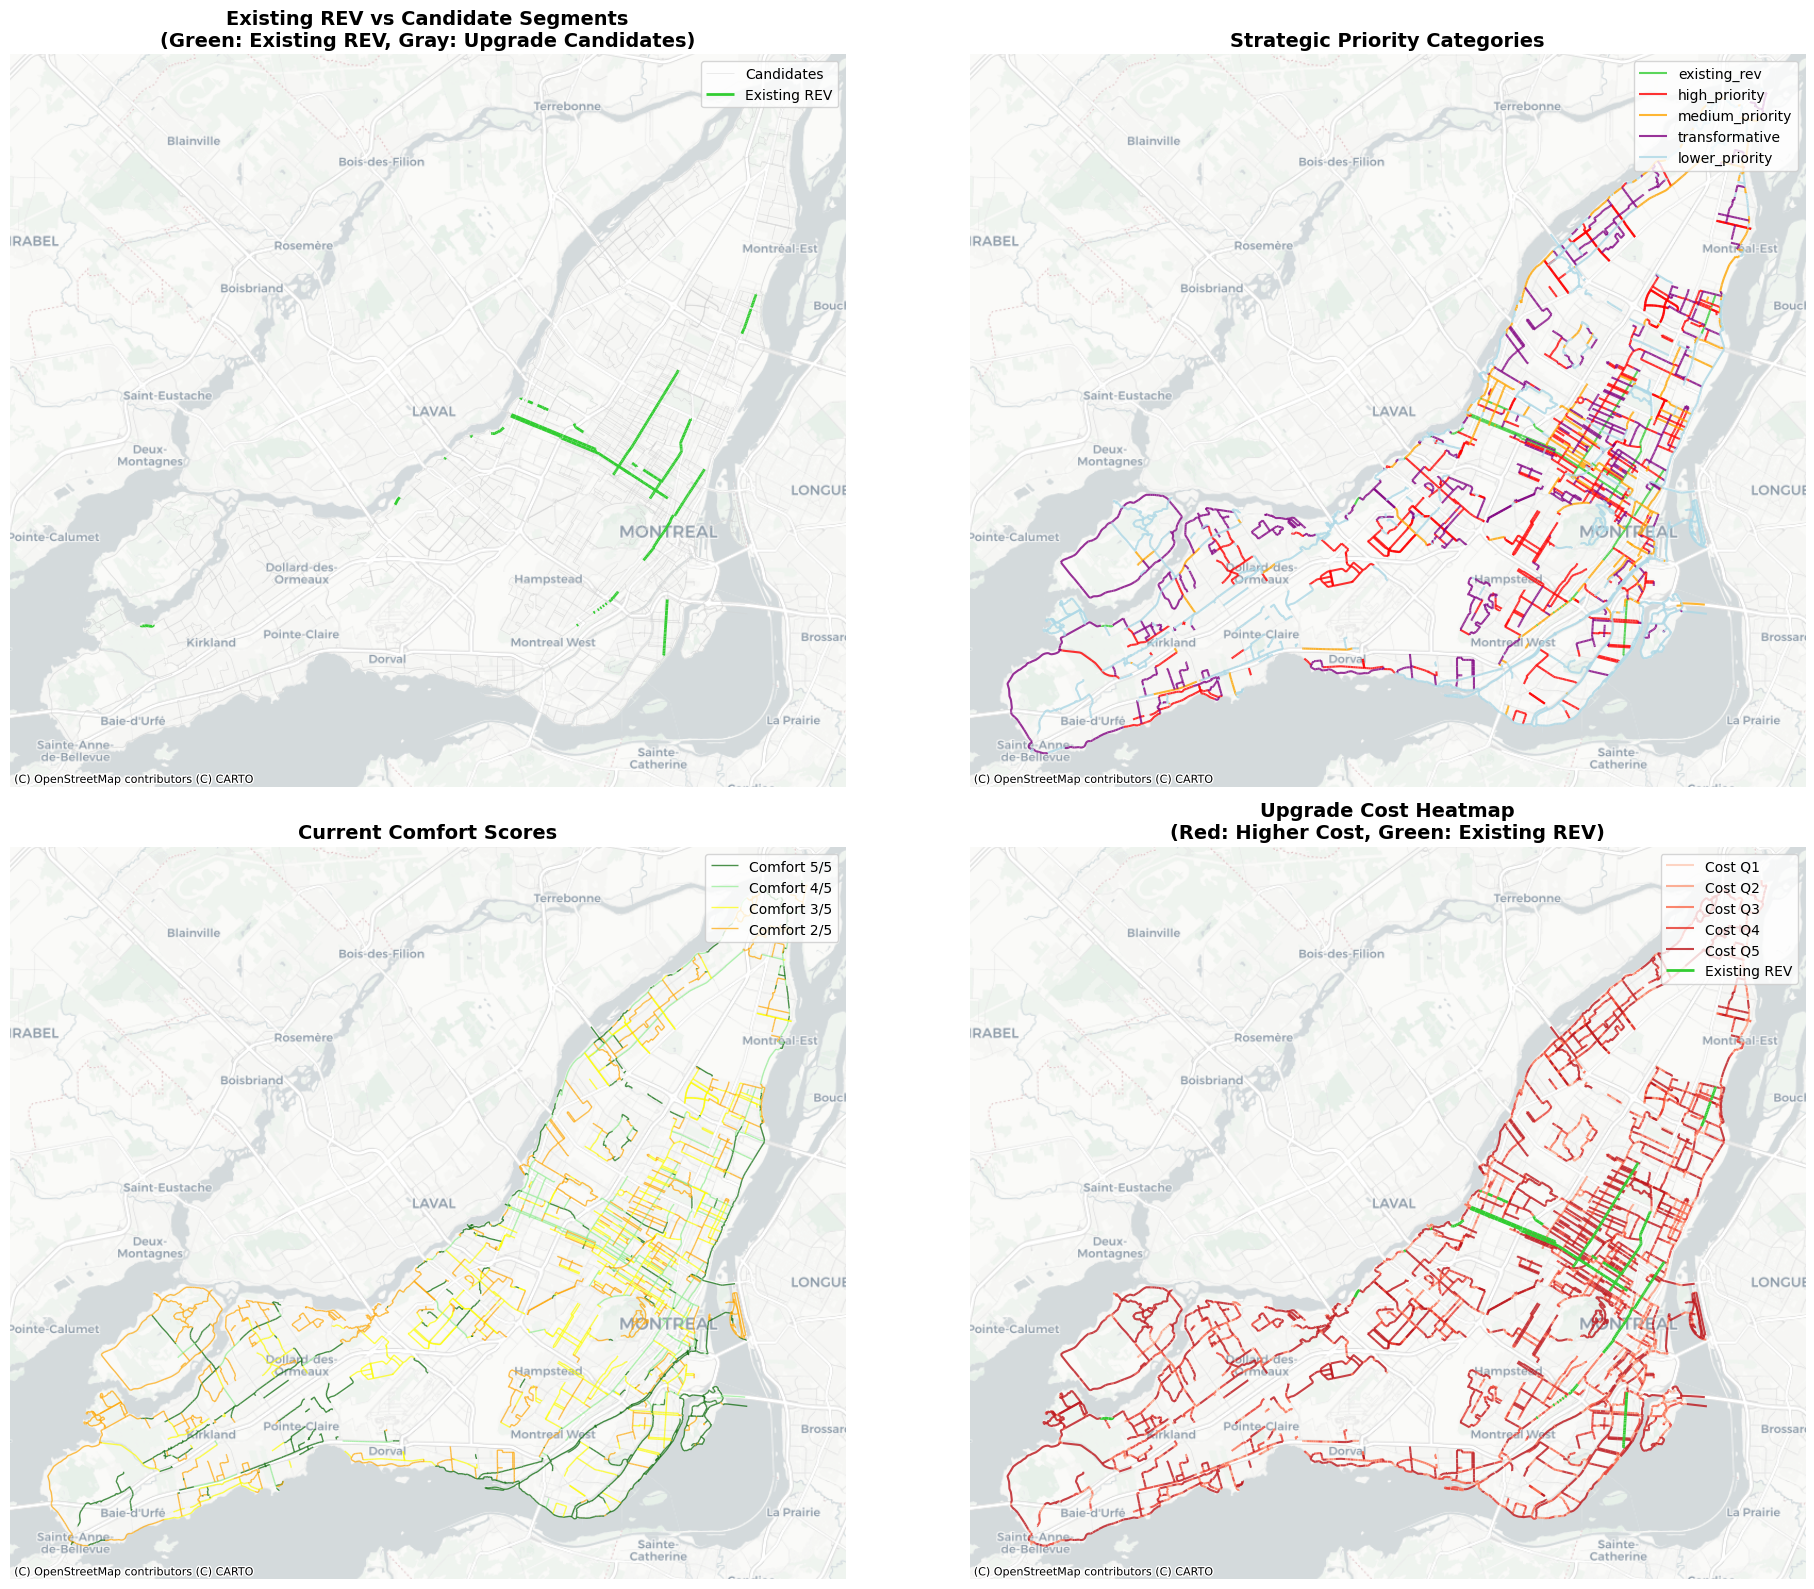


=== MAP INSIGHTS ===
• Existing REV coverage: 42.2 km
• High-priority segments: 285.5 km
• Number of REV segments: 441
• REV corridors identified: 12

=== FOCUSED REV CORRIDOR MAP ===
Plotting 12 REV corridors...


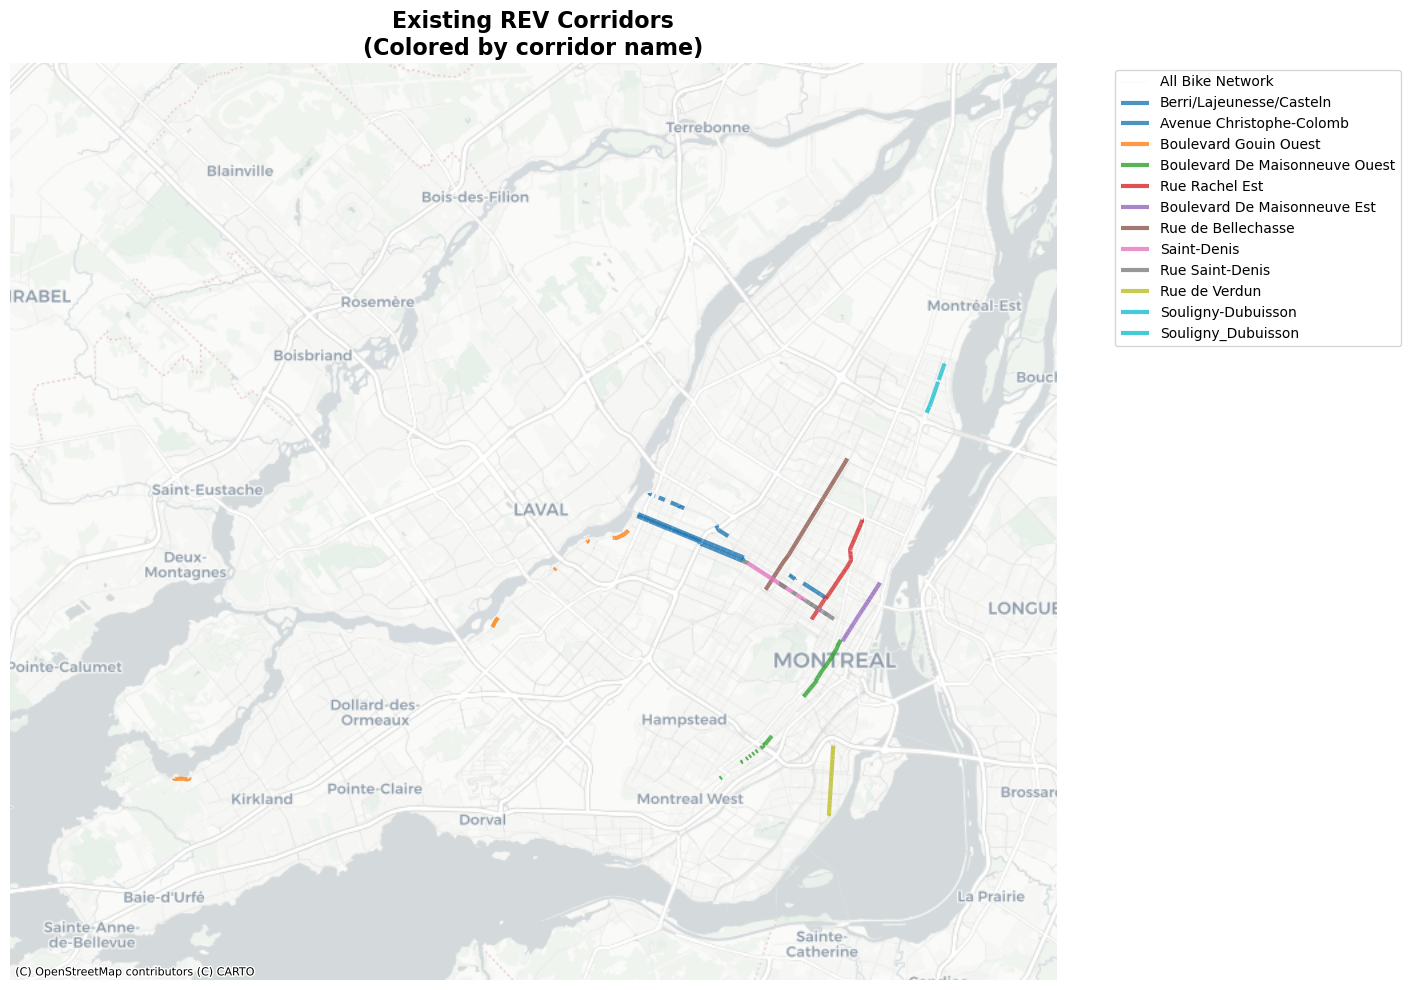


=== REV CORRIDOR STATISTICS ===
• Berri/Lajeunesse/Casteln: 13.6 km (58 segments)
• Avenue Christophe-Colomb: 4.6 km (36 segments)
• Boulevard Gouin Ouest: 2.9 km (28 segments)
• Boulevard De Maisonneuve Ouest: 5.6 km (45 segments)
• Rue Rachel Est: 6.6 km (64 segments)
• Boulevard De Maisonneuve Est: 4.0 km (34 segments)
• Rue de Bellechasse: 8.9 km (71 segments)
• Saint-Denis: 3.6 km (19 segments)
• Rue Saint-Denis: 3.5 km (31 segments)
• Rue de Verdun: 4.1 km (30 segments)
• Souligny-Dubuisson: 2.4 km (22 segments)
• Souligny_Dubuisson: 0.5 km (3 segments)
✅ Visualization complete!


In [38]:
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import pandas as pd

def plot_final_network(final_network):
    """
    Create a comprehensive visualization of the final network
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    # Convert to Web Mercator for basemap
    final_network_web = final_network.to_crs(epsg=3857)
    
    # Plot 1: REV vs Candidate segments
    print("Creating REV vs Candidate map...")
    ax1 = axes[0]
    
    # Plot using GeoPandas built-in plotting
    candidates = final_network_web[final_network_web['is_candidate']]
    existing_rev = final_network_web[~final_network_web['is_candidate']]
    
    # Plot candidates first (background)
    candidates.plot(ax=ax1, color='lightgray', linewidth=0.5, alpha=0.6, label='Candidates')
    # Plot existing REV on top
    existing_rev.plot(ax=ax1, color='limegreen', linewidth=2, label='Existing REV')
    
    ax1.set_title('Existing REV vs Candidate Segments\n(Green: Existing REV, Gray: Upgrade Candidates)', fontsize=14, fontweight='bold')
    ax1.legend()
    
    # Plot 2: Strategic Priority Categories
    print("Creating strategic priority map...")
    ax2 = axes[1]
    
    priority_colors = {
        'existing_rev': 'limegreen',
        'high_priority': 'red',
        'medium_priority': 'orange', 
        'transformative': 'purple',
        'lower_priority': 'lightblue'
    }
    
    for priority, color in priority_colors.items():
        priority_data = final_network_web[final_network_web['priority_category'] == priority]
        if len(priority_data) > 0:
            priority_data.plot(ax=ax2, color=color, linewidth=1.5, label=priority, alpha=0.8)
    
    ax2.set_title('Strategic Priority Categories', fontsize=14, fontweight='bold')
    ax2.legend()
    
    # Plot 3: Comfort Score Distribution - use the correct column name
    print("Creating comfort score map...")
    ax3 = axes[2]
    
    comfort_colors = {
        5: 'darkgreen',
        4: 'lightgreen', 
        3: 'yellow',
        2: 'orange',
        1: 'red'
    }
    
    # Use comfort_score_detailed instead of current_comfort
    for comfort, color in comfort_colors.items():
        comfort_data = final_network_web[final_network_web['comfort_score_detailed'] == comfort]
        if len(comfort_data) > 0:
            comfort_data.plot(ax=ax3, color=color, linewidth=1, label=f'Comfort {comfort}/5', alpha=0.7)
    
    ax3.set_title('Current Comfort Scores', fontsize=14, fontweight='bold')
    ax3.legend()
    
    # Plot 4: Upgrade Cost Heatmap
    print("Creating upgrade cost map...")
    ax4 = axes[3]
    
    # Plot candidates with color based on cost
    candidates_only = final_network_web[final_network_web['is_candidate']]
    if len(candidates_only) > 0:
        # Use quantiles for better color distribution
        candidates_only = candidates_only.copy()
        candidates_only['cost_quantile'] = pd.qcut(candidates_only['upgrade_cost_est'], q=5, labels=False)
        
        # Plot each quantile with different color intensity
        for quantile in range(5):
            quantile_data = candidates_only[candidates_only['cost_quantile'] == quantile]
            color_intensity = 0.2 + (quantile * 0.15)  # Range from 0.2 to 0.8
            quantile_data.plot(ax=ax4, color=plt.cm.Reds(color_intensity), linewidth=1.5, alpha=0.8,
                             label=f'Cost Q{quantile+1}')
    
    # Add existing REV for reference
    existing_rev.plot(ax=ax4, color='limegreen', linewidth=2, label='Existing REV')
    ax4.set_title('Upgrade Cost Heatmap\n(Red: Higher Cost, Green: Existing REV)', fontsize=14, fontweight='bold')
    ax4.legend()
    
    # Add basemaps to all subplots
    print("Adding basemaps...")
    for ax in axes:
        try:
            ctx.add_basemap(ax, crs=final_network_web.crs, 
                           source=ctx.providers.CartoDB.Positron)
        except:
            print("Could not add basemap, continuing without...")
        
        ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()
    
    # Print some key insights
    print("\n=== MAP INSIGHTS ===")
    print(f"• Existing REV coverage: {final_network[~final_network['is_candidate']]['length_km'].sum():.1f} km")
    print(f"• High-priority segments: {final_network[final_network['priority_category'] == 'high_priority']['length_km'].sum():.1f} km")
    print(f"• Number of REV segments: {len(existing_rev)}")
    print(f"• REV corridors identified: {final_network['rev_corridor_matched'].nunique()}")

# Create the visualization
print("Generating comprehensive network visualization...")
plot_final_network(final_network)

# Additional: Simple focused map of just REV corridors
print("\n=== FOCUSED REV CORRIDOR MAP ===")
plt.figure(figsize=(15, 10))

# Convert to Web Mercator
final_network_web = final_network.to_crs(epsg=3857)

# Get REV segments
rev_segments = final_network_web[~final_network_web['is_candidate']]

# Plot all bike network in background
final_network_web.plot(ax=plt.gca(), color='lightgray', linewidth=0.3, alpha=0.3, label='All Bike Network')

# Plot REV segments colored by corridor
unique_corridors = rev_segments['rev_corridor_matched'].dropna().unique()
print(f"Plotting {len(unique_corridors)} REV corridors...")

if len(unique_corridors) > 0:
    # Use a colormap for the corridors
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_corridors)))

    for i, corridor in enumerate(unique_corridors):
        corridor_data = rev_segments[rev_segments['rev_corridor_matched'] == corridor]
        corridor_data.plot(ax=plt.gca(), color=colors[i], linewidth=3, label=f'{corridor}', alpha=0.8)

    try:
        ctx.add_basemap(plt.gca(), crs=final_network_web.crs, source=ctx.providers.CartoDB.Positron)
    except:
        pass

    plt.title('Existing REV Corridors\n(Colored by corridor name)', fontsize=16, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print corridor statistics
    print("\n=== REV CORRIDOR STATISTICS ===")
    for corridor in unique_corridors:
        corridor_data = rev_segments[rev_segments['rev_corridor_matched'] == corridor]
        corridor_length = corridor_data.geometry.length.sum() / 1000
        segment_count = len(corridor_data)
        print(f"• {corridor}: {corridor_length:.1f} km ({segment_count} segments)")
else:
    print("No REV corridors found to plot")

print("✅ Visualization complete!")

Adding population density with proper geometric calculations...
=== ADDING POPULATION DENSITY PROPERLY ===
Available columns: ['csd_population_2021', 'population_density']
Using csd_population_2021 data...
Calculating segment influence areas...
Population density range: 5176 to 215861725 people/km²
Segments with valid density: 8899

=== POPULATION DENSITY SUMMARY ===
count    8.899000e+03
mean     9.887184e+07
std      5.885578e+07
min      5.175541e+03
25%      5.703663e+07
50%      1.058956e+08
75%      1.334457e+08
max      2.158617e+08
Name: population_density, dtype: float64


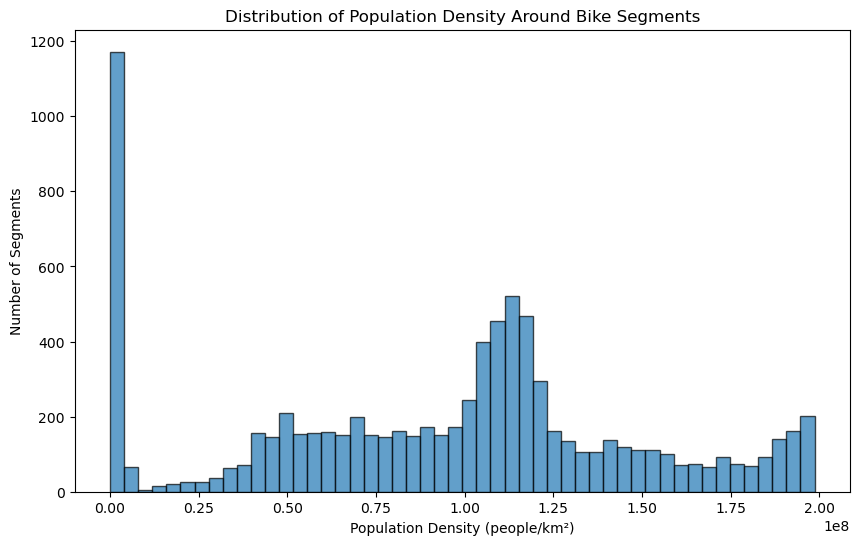


=== SIMPLE POPULATION DENSITY MAP ===


ImportError: The 'mapclassify' package is required to use the 'scheme' keyword.

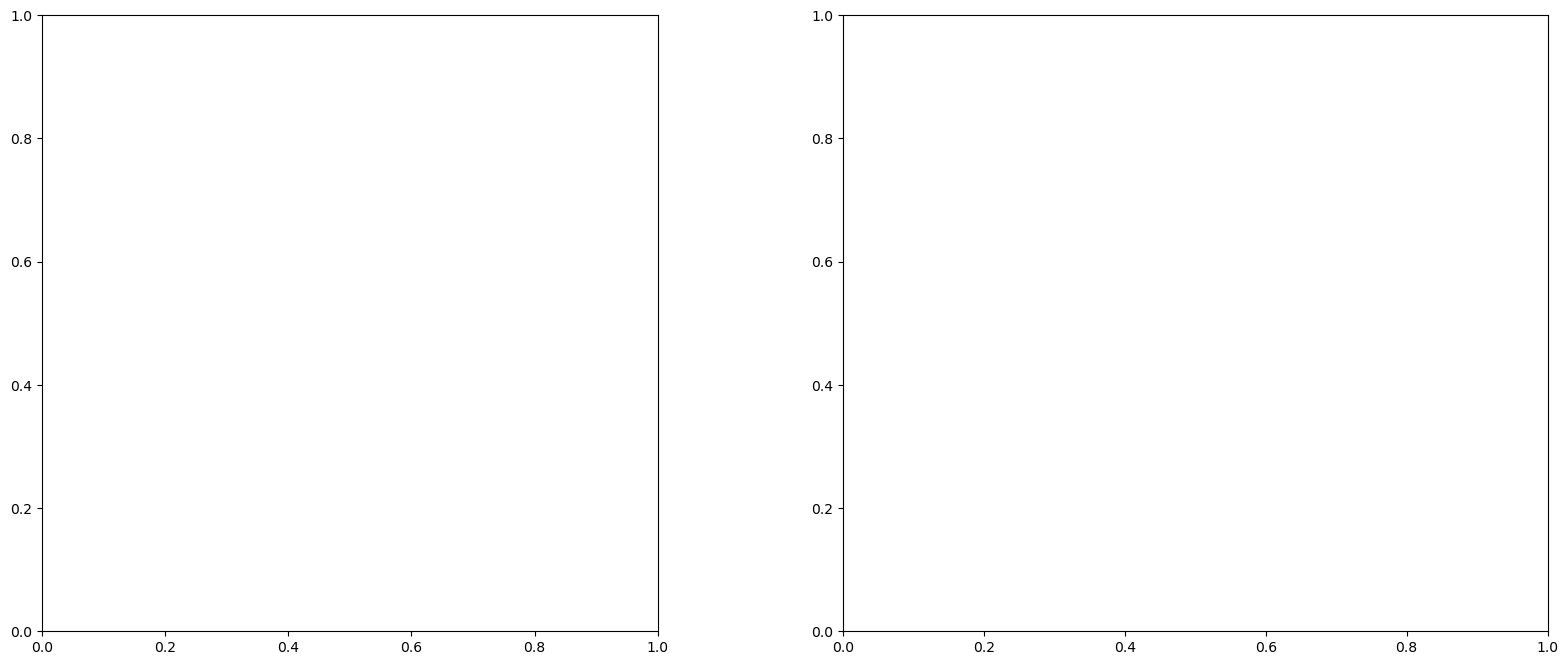

In [42]:
def add_population_density_properly(final_network):
    """
    Properly add population density using the existing census data
    """
    print("=== ADDING POPULATION DENSITY PROPERLY ===")
    
    # Check what population data we have
    print("Available columns:", [col for col in final_network.columns if 'pop' in col.lower()])
    
    # We have 'csd_population_2021' - let's use that
    if 'csd_population_2021' in final_network.columns:
        print("Using csd_population_2021 data...")
        
        # Convert MultiLineString to LineString for area calculation
        def calculate_segment_area(geometry):
            """Calculate approximate area influence of a segment"""
            try:
                # Create a buffer around the segment (50m buffer = 100m wide influence area)
                buffer_distance = 50  # meters
                buffered = geometry.buffer(buffer_distance)
                return buffered.area / 1000000  # Convert to km²
            except:
                # Fallback: use segment length * typical street width
                return geometry.length * 0.03 / 1000  # 30m width in km²
        
        # Calculate area for each segment
        print("Calculating segment influence areas...")
        final_network['influence_area_km2'] = final_network.geometry.apply(calculate_segment_area)
        
        # Calculate population density (population per km² in the CSD)
        # Note: This assumes uniform density within each CSD
        final_network['population_density'] = final_network['csd_population_2021'] / final_network['influence_area_km2']
        
        # Handle infinite values from zero-area segments
        final_network['population_density'] = final_network['population_density'].replace([np.inf, -np.inf], 0)
        
        print(f"Population density range: {final_network['population_density'].min():.0f} to {final_network['population_density'].max():.0f} people/km²")
        print(f"Segments with valid density: {(final_network['population_density'] > 0).sum()}")
        
        return final_network
    else:
        print("No population data found in columns")
        return final_network

# Add population density properly
print("Adding population density with proper geometric calculations...")
final_network_with_pop = add_population_density_properly(final_network)

# Check the results
if 'population_density' in final_network_with_pop.columns:
    print("\n=== POPULATION DENSITY SUMMARY ===")
    print(final_network_with_pop['population_density'].describe())
    
    # Remove infinite and very large values for visualization
    pop_density_clean = final_network_with_pop['population_density'].replace([np.inf, -np.inf], np.nan)
    pop_density_clean = pop_density_clean[pop_density_clean < pop_density_clean.quantile(0.95)]  # Remove outliers
    
    plt.figure(figsize=(10, 6))
    plt.hist(pop_density_clean.dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Population Density Around Bike Segments')
    plt.xlabel('Population Density (people/km²)')
    plt.ylabel('Number of Segments')
    plt.show()

In [44]:
final_network_with_pop.isnull().sum()

province_territory           0
municipality                 0
source_data_id            8899
record_id                    0
source_class                 0
source_class_secondary    6892
canbics_class                0
surface_type              8899
width_m                   8899
length_km                    0
csdname                      0
cmaname                     56
csd_population_2021          0
geometry                     0
comfort_score                0
comfort_score_detailed       0
is_rev_overlap               0
overlap_ratio                0
rev_corridor_matched      8458
infra_type                   0
is_existing_rev_final        0
edge_id                      0
upgrade_potential            0
length_m                     0
priority_category            0
upgrade_cost_est             0
is_candidate                 0
population_density           0
influence_area_km2           0
dtype: int64


=== SIMPLE POPULATION DENSITY MAP ===


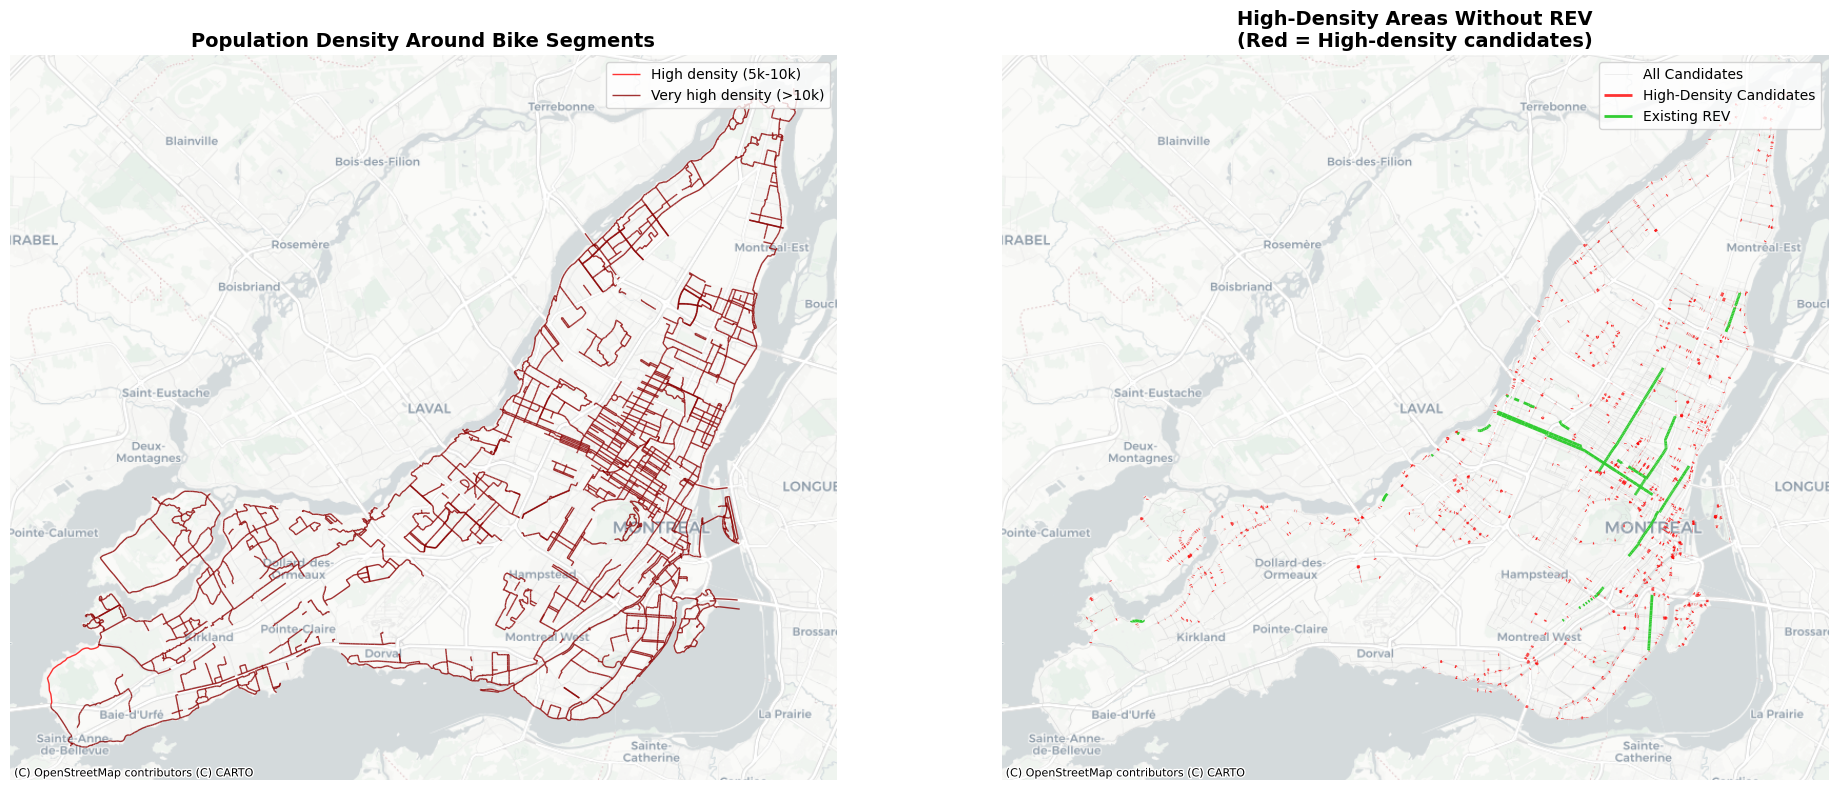


=== POPULATION DENSITY INSIGHTS ===
Average density around candidates: 98087172 people/km²
Average density around existing REV: 113921065 people/km²
High-density candidate segments: 2115
High-density candidate length: 50.0 km

Density distribution (candidates):
  Low (<1k): 0 segments
  Medium (1k-5k): 0 segments
  High (5k-10k): 3 segments
  Very high (>10k): 8455 segments

=== FINAL OPTIMIZATION DATASET ===
Final dataset shape: (8899, 10)
Columns: ['edge_id', 'geometry', 'length_m', 'infra_type', 'current_comfort', 'upgrade_cost_est', 'priority_category', 'is_candidate', 'population_density', 'comfort_gap']

=== OPTIMIZATION READY SUMMARY ===
• Total segments: 8899
• Existing REV: 42.2 km
• Upgrade candidates: 8458 segments
• Total upgrade cost: $2379.6M
• Average population density around candidates: 98087172 people/km²

✅ OPTIMIZATION DATASET READY!
We now have:
1. ✅ Accurate REV identification (42.2 km)
2. ✅ Strategic priority categories
3. ✅ Cost estimates for upgrades
4. ✅ Popu

In [46]:
def plot_population_density_simple(final_network_with_pop):
    """
    Simple population density visualization without mapclassify
    """
    print("\n=== SIMPLE POPULATION DENSITY MAP ===")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Convert to Web Mercator
    network_web = final_network_with_pop.to_crs(epsg=3857)
    
    # Plot 1: Population density using manual classification
    if 'population_density' in network_web.columns:
        # Clean the data
        density_clean = network_web['population_density'].replace([np.inf, -np.inf], np.nan).fillna(0)
        
        # Manual classification without mapclassify
        def get_density_color(density):
            if density == 0:
                return 'lightgrey'
            elif density < 1000:
                return 'yellow'
            elif density < 5000:
                return 'orange'
            elif density < 10000:
                return 'red'
            else:
                return 'darkred'
        
        # Add color column to the dataframe
        network_web['density_color'] = density_clean.apply(get_density_color)
        
        # Plot by color groups (this handles MultiLineString properly)
        for color in ['yellow', 'orange', 'red', 'darkred', 'lightgrey']:
            color_data = network_web[network_web['density_color'] == color]
            if len(color_data) > 0:
                if color == 'yellow':
                    label = 'Low density (<1k)'
                elif color == 'orange':
                    label = 'Medium density (1k-5k)'
                elif color == 'red':
                    label = 'High density (5k-10k)'
                elif color == 'darkred':
                    label = 'Very high density (>10k)'
                else:
                    label = 'No data'
                
                color_data.plot(ax=ax1, color=color, linewidth=1, alpha=0.8, label=label)
        
        ax1.legend(loc='upper right')
        
        try:
            ctx.add_basemap(ax1, crs=network_web.crs, source=ctx.providers.CartoDB.Positron)
        except:
            pass
        
        ax1.set_title('Population Density Around Bike Segments', fontsize=14, fontweight='bold')
        ax1.set_axis_off()
    
    # Plot 2: High-density areas without REV (opportunity areas)
    candidates = network_web[network_web['is_candidate']]
    existing_rev = network_web[~network_web['is_candidate']]
    
    if 'population_density' in candidates.columns:
        # Find high-density candidates (top 25%)
        density_clean = candidates['population_density'].replace([np.inf, -np.inf], np.nan)
        if len(density_clean) > 0:
            high_density_threshold = density_clean.quantile(0.75)
            high_density_candidates = candidates[candidates['population_density'] > high_density_threshold]
            
            # Plot all candidates in light gray
            candidates.plot(ax=ax2, color='lightgray', linewidth=0.5, alpha=0.5, label='All Candidates')
            # Plot high-density candidates in red
            if len(high_density_candidates) > 0:
                high_density_candidates.plot(ax=ax2, color='red', linewidth=2, alpha=0.8, label='High-Density Candidates')
            # Plot existing REV in green
            existing_rev.plot(ax=ax2, color='limegreen', linewidth=2, label='Existing REV')
            
            try:
                ctx.add_basemap(ax2, crs=network_web.crs, source=ctx.providers.CartoDB.Positron)
            except:
                pass
            
            ax2.set_title('High-Density Areas Without REV\n(Red = High-density candidates)', fontsize=14, fontweight='bold')
            ax2.legend()
            ax2.set_axis_off()
        else:
            ax2.text(0.5, 0.5, 'No population density data available', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_axis_off()
    
    plt.tight_layout()
    plt.show()
    
    # Print key insights
    if 'population_density' in network_web.columns:
        candidates_clean = candidates['population_density'].replace([np.inf, -np.inf], np.nan)
        existing_rev_clean = existing_rev['population_density'].replace([np.inf, -np.inf], np.nan)
        
        print(f"\n=== POPULATION DENSITY INSIGHTS ===")
        if len(candidates_clean) > 0:
            print(f"Average density around candidates: {candidates_clean.mean():.0f} people/km²")
        if len(existing_rev_clean) > 0:
            print(f"Average density around existing REV: {existing_rev_clean.mean():.0f} people/km²")
        
        if len(high_density_candidates) > 0:
            print(f"High-density candidate segments: {len(high_density_candidates)}")
            print(f"High-density candidate length: {high_density_candidates['length_km'].sum():.1f} km")
        
        # Density distribution analysis
        if len(candidates_clean) > 0:
            print(f"\nDensity distribution (candidates):")
            print(f"  Low (<1k): {len(candidates_clean[candidates_clean < 1000])} segments")
            print(f"  Medium (1k-5k): {len(candidates_clean[(candidates_clean >= 1000) & (candidates_clean < 5000)])} segments")
            print(f"  High (5k-10k): {len(candidates_clean[(candidates_clean >= 5000) & (candidates_clean < 10000)])} segments")
            print(f"  Very high (>10k): {len(candidates_clean[candidates_clean >= 10000])} segments")

# Create the visualization
plot_population_density_simple(final_network_with_pop)

# Final optimization dataset with population density
print("\n=== FINAL OPTIMIZATION DATASET ===")
optimization_columns = [
    'record_id', 'geometry', 'length_m', 'source_class', 'comfort_score_detailed', 
    'upgrade_cost_est', 'priority_category', 'is_candidate'
]

if 'population_density' in final_network_with_pop.columns:
    optimization_columns.append('population_density')
if 'priority_with_density' in final_network_with_pop.columns:
    optimization_columns.append('priority_with_density')

# Create final optimization dataset
final_optimization_data = final_network_with_pop[optimization_columns].copy()

# Rename columns to standard names
column_mapping = {
    'record_id': 'edge_id',
    'source_class': 'infra_type',
    'comfort_score_detailed': 'current_comfort'
}
final_optimization_data = final_optimization_data.rename(columns=column_mapping)

# Add comfort_gap
final_optimization_data['comfort_gap'] = 5 - final_optimization_data['current_comfort']

print(f"Final dataset shape: {final_optimization_data.shape}")
print(f"Columns: {final_optimization_data.columns.tolist()}")

# Summary statistics
print(f"\n=== OPTIMIZATION READY SUMMARY ===")
print(f"• Total segments: {len(final_optimization_data)}")
print(f"• Existing REV: {final_optimization_data[~final_optimization_data['is_candidate']]['length_m'].sum() / 1000:.1f} km")
print(f"• Upgrade candidates: {final_optimization_data['is_candidate'].sum()} segments")
print(f"• Total upgrade cost: ${final_optimization_data[final_optimization_data['is_candidate']]['upgrade_cost_est'].sum() / 1e6:.1f}M")

if 'population_density' in final_optimization_data.columns:
    candidates_with_pop = final_optimization_data[final_optimization_data['is_candidate']]
    pop_density_clean = candidates_with_pop['population_density'].replace([np.inf, -np.inf], np.nan)
    if len(pop_density_clean) > 0:
        print(f"• Average population density around candidates: {pop_density_clean.mean():.0f} people/km²")

print("\n✅ OPTIMIZATION DATASET READY!")
print("We now have:")
print("1. ✅ Accurate REV identification (42.2 km)")
print("2. ✅ Strategic priority categories") 
print("3. ✅ Cost estimates for upgrades")
print("4. ✅ Population density data")
print("5. ✅ Clean, structured data for optimization")


Adding proper population density data...
=== ADDING PROPER POPULATION DENSITY ===
CSD Populations:
                      csdname  csd_population_2021
2                    Montréal            1762949.0
1         Dollard-Des Ormeaux              48403.0
6972           Côte-Saint-Luc              34504.0
13              Pointe-Claire              33488.0
252             Saint-Lambert              22761.0
629                Mont-Royal              20953.0
244                 Westmount              19658.0
0                    Kirkland              19413.0
515                    Dorval              19302.0
170              Beaconsfield              19277.0
1105           Montréal-Ouest               5115.0
1066  Sainte-Anne-de-Bellevue               5027.0
445              Montréal-Est               4394.0
688               Baie-D'Urfé               3764.0
590                Senneville                951.0
Kirkland: 19,413 people / 9.6 km² = 2,014 people/km²
Dollard-Des Ormeaux: 48,403 peop

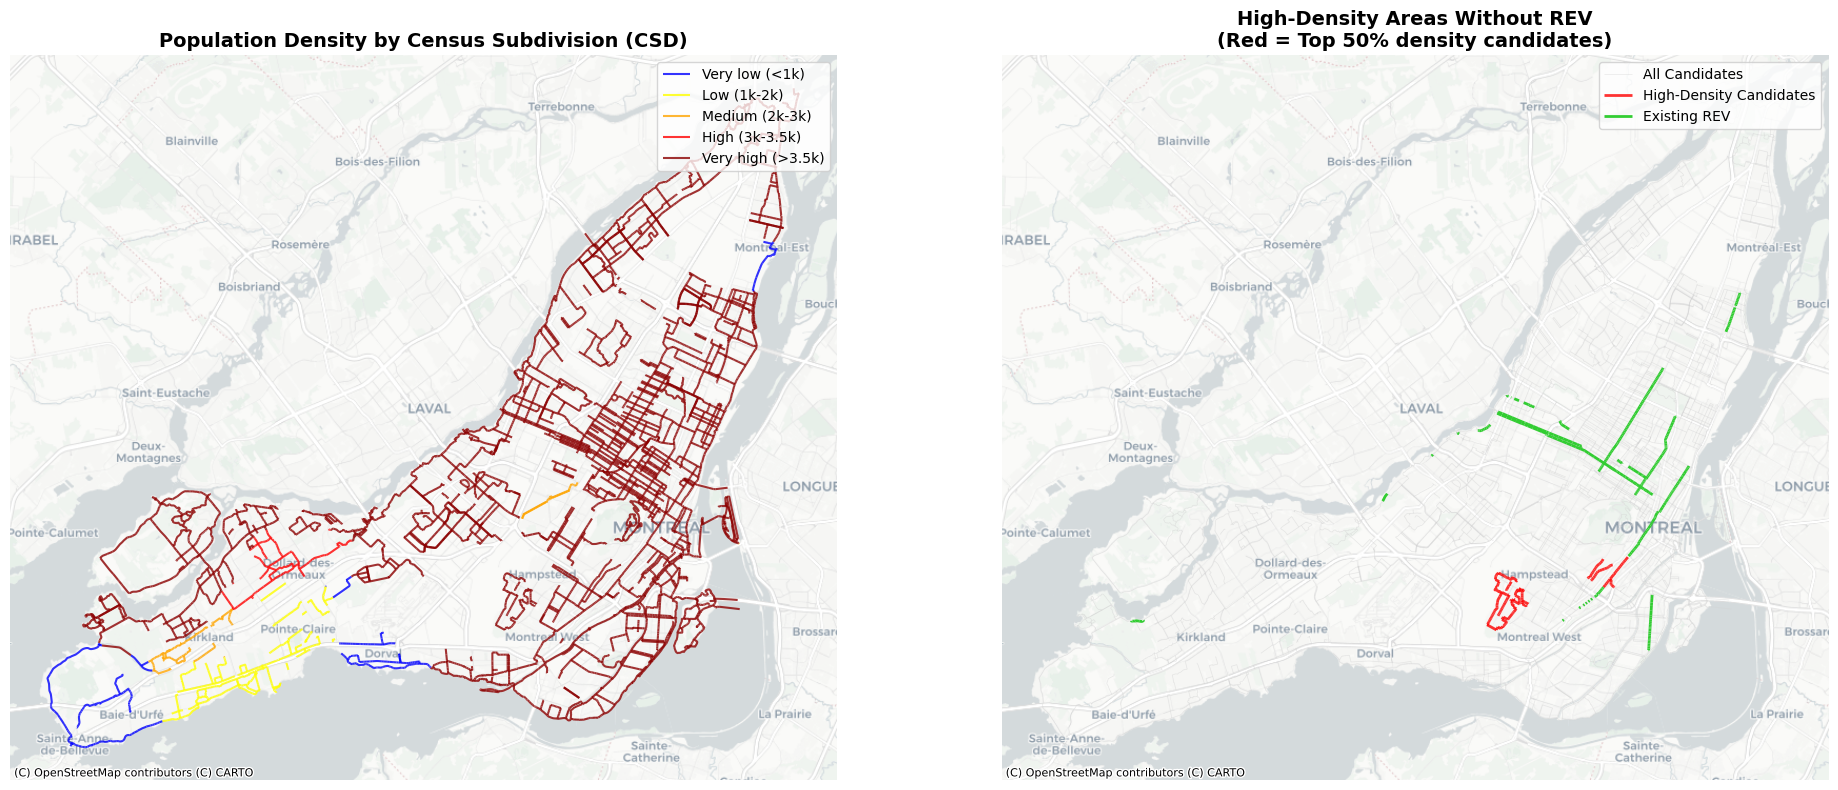


=== PROPER POPULATION DENSITY INSIGHTS ===
Average density around candidates: 4,445 people/km²
Average density around existing REV: 4,828 people/km²
High-density candidate segments: 173
High-density candidate length: 18.8 km

Density distribution (candidates):
  Very low (<1k): 318 segments
  Low (1k-2k): 375 segments
  Medium (2k-3k): 199 segments
  High (3k-3.5k): 162 segments
  Very high (>3.5k): 7404 segments

=== FINAL OPTIMIZATION DATASET WITH PROPER DENSITY ===
Final dataset shape: (8899, 10)
Columns: ['edge_id', 'geometry', 'length_m', 'infra_type', 'current_comfort', 'upgrade_cost_est', 'priority_category', 'is_candidate', 'population_density', 'comfort_gap']

=== FINAL OPTIMIZATION SUMMARY ===
• Total segments: 8899
• Existing REV: 42.2 km
• Upgrade candidates: 8458 segments
• Total upgrade cost: $2379.6M
• Average population density around candidates: 4,445 people/km²

✅ PROPER OPTIMIZATION DATASET READY!


In [62]:
def add_proper_population_density(final_network):
    """
    Add proper population density using CSD-level data
    """
    print("=== ADDING PROPER POPULATION DENSITY ===")
    
    # Get unique CSDs and their populations
    csd_populations = final_network[['csdname', 'csd_population_2021']].drop_duplicates()
    print("CSD Populations:")
    print(csd_populations.sort_values('csd_population_2021', ascending=False))
    
    # We need the area of each CSD to calculate density
    # Since we don't have CSD areas, let's use approximate areas for Montreal boroughs
    # Source: Wikipedia/OpenData Montreal
    csd_areas_km2 = {
        'Montréal': 365.13,           # Entire Montreal island
        'Dorval': 20.91,
        'Westmount': 4.02,
        'Mont-Royal': 7.66,
        'Côte-Saint-Luc': 6.95,
        'Pointe-Claire': 18.88,
        'Kirkland': 9.64,
        'Beaconsfield': 10.99,
        'Dollard-Des Ormeaux': 14.97,
        'Sainte-Anne-de-Bellevue': 10.53,
        'Baie-D\'Urfé': 6.03,
        'Senneville': 7.45,
        'Montréal-Ouest': 1.39,
        'Montréal-Est': 12.31,
        'Saint-Lambert': 10.11
    }
    
    # Calculate proper population density for each CSD
    csd_densities = {}
    for csd in csd_populations['csdname'].unique():
        population = csd_populations[csd_populations['csdname'] == csd]['csd_population_2021'].iloc[0]
        area = csd_areas_km2.get(csd, 10.0)  # Default to 10 km² if unknown
        density = population / area
        csd_densities[csd] = density
        print(f"{csd}: {population:,.0f} people / {area:.1f} km² = {density:,.0f} people/km²")
    
    # Add proper population density to the network
    final_network['population_density'] = final_network['csdname'].map(csd_densities)
    
    print(f"\nPopulation density range: {final_network['population_density'].min():,.0f} to {final_network['population_density'].max():,.0f} people/km²")
    
    return final_network

# Add proper population density
print("Adding proper population density data...")
final_network_proper_pop = add_proper_population_density(final_network)

# Create proper visualization
def plot_proper_population_density(final_network):
    """
    Plot proper population density visualization
    """
    print("\n=== PROPER POPULATION DENSITY MAP ===")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Convert to Web Mercator
    network_web = final_network.to_crs(epsg=3857)
    
    # Plot 1: Population density by CSD
    if 'population_density' in network_web.columns:
        # Manual classification with realistic ranges for urban areas
        def get_proper_density_color(density):
            if density < 1000:
                return 'blue'
            elif density < 2000:
                return 'yellow'
            elif density < 3000:
                return 'orange'
            elif density < 3500:
                return 'red'
            else:
                return 'darkred'
        
        # Add color column
        network_web['density_color'] = network_web['population_density'].apply(get_proper_density_color)
        
        # Plot by color groups
        for color in ['blue', 'yellow', 'orange', 'red', 'darkred']:
            color_data = network_web[network_web['density_color'] == color]
            if len(color_data) > 0:
                if color == 'blue':
                    label = 'Very low (<1k)'
                elif color == 'yellow':
                    label = 'Low (1k-2k)'
                elif color == 'orange':
                    label = 'Medium (2k-3k)'
                elif color == 'red':
                    label = 'High (3k-3.5k)'
                else:
                    label = 'Very high (>3.5k)'
                
                color_data.plot(ax=ax1, color=color, linewidth=1.5, alpha=0.8, label=label)
        
        ax1.legend(loc='upper right')
        
        try:
            ctx.add_basemap(ax1, crs=network_web.crs, source=ctx.providers.CartoDB.Positron)
        except:
            pass
        
        ax1.set_title('Population Density by Census Subdivision (CSD)', fontsize=14, fontweight='bold')
        ax1.set_axis_off()
    
    # Plot 2: High-density areas without REV
    candidates = network_web[network_web['is_candidate']]
    existing_rev = network_web[~network_web['is_candidate']]
    
    if 'population_density' in candidates.columns:
        # Find high-density candidates (top 40%)
        high_density_threshold = candidates['population_density'].quantile(0.5)
        high_density_candidates = candidates[candidates['population_density'] > high_density_threshold]
        
        # Plot all candidates in light gray
        candidates.plot(ax=ax2, color='lightgray', linewidth=0.5, alpha=0.5, label='All Candidates')
        # Plot high-density candidates in red
        high_density_candidates.plot(ax=ax2, color='red', linewidth=2, alpha=0.8, label='High-Density Candidates')
        # Plot existing REV in green
        existing_rev.plot(ax=ax2, color='limegreen', linewidth=2, label='Existing REV')
        
        try:
            ctx.add_basemap(ax2, crs=network_web.crs, source=ctx.providers.CartoDB.Positron)
        except:
            pass
        
        ax2.set_title('High-Density Areas Without REV\n(Red = Top 50% density candidates)', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.set_axis_off()
    
    plt.tight_layout()
    plt.show()
    
    # Print proper insights
    if 'population_density' in network_web.columns:
        candidates_pop = candidates['population_density']
        existing_rev_pop = existing_rev['population_density']
        
        print(f"\n=== PROPER POPULATION DENSITY INSIGHTS ===")
        print(f"Average density around candidates: {candidates_pop.mean():,.0f} people/km²")
        print(f"Average density around existing REV: {existing_rev_pop.mean():,.0f} people/km²")
        print(f"High-density candidate segments: {len(high_density_candidates)}")
        print(f"High-density candidate length: {high_density_candidates['length_km'].sum():.1f} km")
        
        # Proper density distribution
        print(f"\nDensity distribution (candidates):")
        print(f"  Very low (<1k): {len(candidates_pop[candidates_pop < 1000])} segments")
        print(f"  Low (1k-2k): {len(candidates_pop[(candidates_pop >= 1000) & (candidates_pop < 2000)])} segments")
        print(f"  Medium (2k-3k): {len(candidates_pop[(candidates_pop >= 2000) & (candidates_pop < 3000)])} segments")
        print(f"  High (3k-3.5k): {len(candidates_pop[(candidates_pop >= 3000) & (candidates_pop < 3500)])} segments")
        print(f"  Very high (>3.5k): {len(candidates_pop[candidates_pop >= 3500])} segments")

# Create proper visualization
plot_proper_population_density(final_network_proper_pop)

# Final optimization dataset with proper population density
print("\n=== FINAL OPTIMIZATION DATASET WITH PROPER DENSITY ===")
final_optimization_data = final_network_proper_pop[[
    'record_id', 'geometry', 'length_m', 'source_class', 'comfort_score_detailed', 
    'upgrade_cost_est', 'priority_category', 'is_candidate', 'population_density'
]].copy()

# Rename columns
final_optimization_data = final_optimization_data.rename(columns={
    'record_id': 'edge_id',
    'source_class': 'infra_type',
    'comfort_score_detailed': 'current_comfort'
})

# Add comfort_gap
final_optimization_data['comfort_gap'] = 5 - final_optimization_data['current_comfort']

print(f"Final dataset shape: {final_optimization_data.shape}")
print(f"Columns: {final_optimization_data.columns.tolist()}")

# Summary statistics
print(f"\n=== FINAL OPTIMIZATION SUMMARY ===")
print(f"• Total segments: {len(final_optimization_data)}")
print(f"• Existing REV: {final_optimization_data[~final_optimization_data['is_candidate']]['length_m'].sum() / 1000:.1f} km")
print(f"• Upgrade candidates: {final_optimization_data['is_candidate'].sum()} segments")
print(f"• Total upgrade cost: ${final_optimization_data[final_optimization_data['is_candidate']]['upgrade_cost_est'].sum() / 1e6:.1f}M")

candidates_with_pop = final_optimization_data[final_optimization_data['is_candidate']]
print(f"• Average population density around candidates: {candidates_with_pop['population_density'].mean():,.0f} people/km²")

print("\n✅ PROPER OPTIMIZATION DATASET READY!")

In [103]:
# Export only the essential files for optimization
print("=== EXPORTING ESSENTIAL OPTIMIZATION FILES ===")

# 1. Export as GeoPackage (for spatial analysis and visualization)
gpkg_path = "montreal_rev_optimization.gpkg"
final_optimization_data.to_file(gpkg_path, driver="GPKG")
print(f"✅ GeoPackage exported: {gpkg_path}")
print(f"   - Contains geometry for maps and spatial analysis")
print(f"   - {len(final_optimization_data)} segments, {final_optimization_data['length_m'].sum()/1000:.1f} km total")

# 2. Export as CSV (for optimization models - no geometry)
csv_path = "montreal_rev_optimization.csv"
csv_data = final_optimization_data.drop(columns=['geometry'])
csv_data.to_csv(csv_path, index=False)
print(f"✅ CSV exported: {csv_path}")
print(f"   - Tabular data for mathematical optimization")
print(f"   - Ready for Python, Gurobi, Excel, etc.")

print("\n" + "="*50)
print("📦 EXPORT COMPLETE - READY FOR OPTIMIZATION")
print("="*50)

# Quick summary
candidates = final_optimization_data[final_optimization_data['is_candidate']]
print(f"""
🎯 OPTIMIZATION PROBLEM SUMMARY:
• Decision variables: {len(candidates):,} candidate segments
• Budget constraint: ${candidates['upgrade_cost_est'].sum()/1e6:.1f}M total potential cost
• Budget available: $300M
• Objective: Maximize comfort × population_density × priority

📁 Files for next phase:
1. {gpkg_path} - For maps and spatial analysis
2. {csv_path} - For optimization modeling

🚀 Next steps:
1. Use CSV in optimization software to select which segments to upgrade
2. Use GeoPackage to visualize the selected segments on a map
3. Analyze connectivity and impact of the optimized solution
""")

=== EXPORTING ESSENTIAL OPTIMIZATION FILES ===
✅ GeoPackage exported: montreal_rev_optimization.gpkg
   - Contains geometry for maps and spatial analysis
   - 8899 segments, 1029.9 km total
✅ CSV exported: montreal_rev_optimization.csv
   - Tabular data for mathematical optimization
   - Ready for Python, Gurobi, Excel, etc.

📦 EXPORT COMPLETE - READY FOR OPTIMIZATION

🎯 OPTIMIZATION PROBLEM SUMMARY:
• Decision variables: 8,458 candidate segments
• Budget constraint: $2379.6M total potential cost
• Budget available: $300M
• Objective: Maximize comfort × population_density × priority

📁 Files for next phase:
1. montreal_rev_optimization.gpkg - For maps and spatial analysis
2. montreal_rev_optimization.csv - For optimization modeling

🚀 Next steps:
1. Use CSV in optimization software to select which segments to upgrade
2. Use GeoPackage to visualize the selected segments on a map
3. Analyze connectivity and impact of the optimized solution



In [102]:
# Simple export to CSV for optimization
print("=== EXPORTING OPTIMIZATION DATASET ===")

# Export to CSV (tabular data for optimization models)
csv_path = "montreal_rev_optimization_data.csv"

# Remove geometry column for CSV and select only essential columns
csv_data = final_optimization_data[[
    'edge_id', 'length_m', 'infra_type', 'current_comfort', 'geometry',
    'upgrade_cost_est', 'priority_category', 'is_candidate', 
    'population_density', 'comfort_gap'
]].copy()

csv_data.to_csv(csv_path, index=False)
print(f"✅ CSV exported: {csv_path}")
print(f"   - {len(csv_data)} segments ready for optimization")
print(f"   - File size: {csv_data.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")

# Quick summary
print(f"\n🎯 OPTIMIZATION DATASET READY:")
print(f"• Total segments: {len(csv_data):,}")
print(f"• Upgrade candidates: {csv_data['is_candidate'].sum():,}")
print(f"• Total upgrade cost: ${csv_data[csv_data['is_candidate']]['upgrade_cost_est'].sum() / 1e6:.1f}M")
print(f"• Budget constraint: $300M")

print(f"\n📊 Key columns for optimization:")
print(f"  - upgrade_cost_est: Budget constraint")
print(f"  - comfort_gap: Benefit measure") 
print(f"  - population_density: Demand weighting")
print(f"  - priority_category: Strategic importance")

print(f"\n📍 Next: Load '{csv_path}' into your optimization software!")

=== EXPORTING OPTIMIZATION DATASET ===
✅ CSV exported: montreal_rev_optimization_data.csv
   - 8899 segments ready for optimization
   - File size: 2.3 MB

🎯 OPTIMIZATION DATASET READY:
• Total segments: 8,899
• Upgrade candidates: 8,458
• Total upgrade cost: $2379.6M
• Budget constraint: $300M

📊 Key columns for optimization:
  - upgrade_cost_est: Budget constraint
  - comfort_gap: Benefit measure
  - population_density: Demand weighting
  - priority_category: Strategic importance

📍 Next: Load 'montreal_rev_optimization_data.csv' into your optimization software!


In [64]:
final_optimization_data.isnull().sum()

edge_id               0
geometry              0
length_m              0
infra_type            0
current_comfort       0
upgrade_cost_est      0
priority_category     0
is_candidate          0
population_density    0
comfort_gap           0
dtype: int64

In [65]:
final_optimization_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8899 entries, 0 to 8898
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   edge_id             8899 non-null   object  
 1   geometry            8899 non-null   geometry
 2   length_m            8899 non-null   float64 
 3   infra_type          8899 non-null   object  
 4   current_comfort     8899 non-null   int64   
 5   upgrade_cost_est    8899 non-null   float64 
 6   priority_category   8899 non-null   object  
 7   is_candidate        8899 non-null   bool    
 8   population_density  8899 non-null   float64 
 9   comfort_gap         8899 non-null   int64   
dtypes: bool(1), float64(3), geometry(1), int64(2), object(3)
memory usage: 634.5+ KB


# Optimization Dataset Column Analysis

| Column | Data Type | Purpose | Pain Points | Optimization Role |
|--------|-----------|------------|------------|-------------------|
| **edge_id** | `object` | **Unique segment identifier** | - Provides unique reference for each bike lane segment<br>- Enables tracking of upgrade decisions | **Decision variable index** - Each edge_id represents a potential decision variable in the optimization model |
| **geometry** | `geometry` | **Spatial representation** | Pain Point 1: **Fragmentation**<br>- Enables network connectivity analysis<br>- Allows calculation of shortest paths and detours | **Network connectivity** - Used to build graph structure for routing and connectivity constraints |
| **length_m** | `float64` | **Segment length in meters** | - Basis for cost calculations<br>- Weight factor for impact assessment | **Cost & impact scaling** - Longer segments have higher costs but also serve more cyclists |
| **infra_type** | `object` | **Current infrastructure type** | Pain Point 2: **Demand-Supply Gap**<br>- Identifies current comfort level<br>- Shows where upgrades are most needed | **Current state baseline** - Determines starting point for comfort improvements |
| **current_comfort** | `int64` | **Current comfort score (1-5)** | Pain Point 2: **Low utilization**<br>- Quantifies current infrastructure quality<br>- Identifies comfort gaps | **Objective function input** - Baseline for calculating improvement potential (5 - current_comfort) |
| **upgrade_cost_est** | `float64` | **Estimated upgrade cost(dollar)** | **Budget constraint**<br>- Enables cost-benefit analysis<br>- Prioritizes cost-effective upgrades | **Constraint variable** - Subject to 300 Million CAD budget constraint in optimization |
| **priority_category** | `object` | **Strategic priority level** | Pain Point 1: **Fragmentation**<br>- Guides corridor completion<br>- Focuses on high-impact connections | **Objective weighting** - Higher weights for critical connectors and high-priority segments |
| **is_candidate** | `bool` | **Upgrade eligibility flag** | - Filters segments that can be upgraded<br>- Excludes existing REV infrastructure | **Decision variable filter** - Only True segments are considered for upgrades in optimization |
| **population_density** | `float64` | **People per km²** | Pain Point 2: **Demand potential**<br>- Prioritizes high-demand areas<br- Maximizes impact per dollar | **Demand weighting** - Higher density areas get priority to serve more people |
| **comfort_gap** | `int64` | **Potential improvement (5 - current)** | Pain Point 2: **Quality gap**<br>- Quantifies upgrade potential<br>- Identifies biggest comfort jumps | **Objective function component** - Direct measure of potential comfort improvement |

---

## How This Addresses Pain Points

### **PAIN POINT 1: Fragmentation & Incomplete Connectivity**
- **`geometry` + `priority_category`**: Enables network connectivity analysis to prioritize segments that complete corridors
- **`is_candidate`**: Focuses optimization on filling gaps rather than rebuilding existing REV
- **`comfort_gap`**: Identifies segments with biggest quality jumps when connected

### **PAIN POINT 2: Demand-Supply Gap & Low Utilization**
- **`population_density`**: Directly addresses demand by prioritizing high-population areas
- **`current_comfort` + `comfort_gap`**: Quantifies the supply quality problem
- **`upgrade_cost_est`**: Ensures cost-effective use of $300M budget to maximize impact
- **`infra_type`**: Shows where basic infrastructure can be upgraded to REV standard

---

## Optimization Model Structure

```python
# Pseudo-code for optimization objective
MAXIMIZE:
  Σ [ comfort_gap × population_density × priority_weight × upgrade_decision ]
  
SUBJECT TO:
  Σ [ upgrade_cost_est × upgrade_decision ] ≤ $300,000,000
  connectivity_constraints (using geometry)
  network_flow_constraints
```

**Where:**
- `upgrade_decision` = Binary variable (0 or 1) for each `edge_id` where `is_candidate=True`
- `priority_weight` = Multiplier based on `priority_category` (existing_rev=0, high_priority=1.2, etc.)
- `connectivity_constraints` = Ensure upgraded segments form connected corridors

---

## Expected Optimization Outcomes

1. **Maximized Connectivity**: Prioritizes segments that connect existing REV corridors
2. **High-Impact Upgrades**: Focuses on areas with high population density and big comfort gaps  
3. **Budget Efficiency**: Stays within $300M while maximizing cyclist comfort
4. **Strategic Alignment**: Follows `priority_category` guidance for corridor completion